## Companion jupyter notebook 
## Global rates of Soil Production independent of Soil Depth
### Confidential manuscript submitted to *Science*
### October 1, 2020
E.J. Harrison

ejharris@ucsd.edu

Python 3.7.4

Import the modules used in this notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
import matplotlib as mpl
from cycler import cycler
import matplotlib.ticker as mtick
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.transforms import Bbox
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Define the functions used in this notebook

In [2]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    """Split (explode) pandas dataframe string entry to separate rows.
    
    Parameters
    ----------
    df : 
    lst_cols :
    fill_value : (optional)
    preserve_index : (optional)
    
    Returns
    --------
    df :
    
    Function copied from : 
    https://stackoverflow.com/questions/12680754/
    split-explode-pandas-dataframe-string-entry-to-separate-rows/40449726#40449726
    
    """
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [3]:
def exponential_fit(x, a, k):
    """Calculate exponential change in *x*
    
    Parameters
    ----------
    x : float ndarray
        The x-values.
    a : float or 1-element float ndarray
        The inital value of the function.
    k : float or 1-element float ndarray
        The rate of growth.
    
    Returns
    -------
    float ndarray
        The fitted y-values.
    
    """
    return a* np.exp(k *x)

## PART I
### Soil arrays and soil production rates

Here, an array of "soil pit" measurements is created:

In [75]:
pits = np.linspace(20, 60, num=10) # min/max 10,80

Calculate a $^{10}$Be production rate for each depth interval, using **equation 1**:

### $P_z = P_o e^{-z\rho / \Lambda}$

#### Variables in arrays: 

$P_o$ = Surface production rate = 5 [atoms g-1 yr-1]

$\rho$ = Soil density = 1.4 [g cm-3]

#### Constant:

$\Lambda$ = Attenuation length = 165 [g cm-1]

In [76]:
def p_rate(i):
    return 5 * np.exp(-i*1.4/165)

In [77]:
Pz_initial_pits = p_rate(pits)

Here, the soil production under each thickness of soil is defined from a linear relationship

In [92]:
def exponential_soil_production_function(z):
    return 200 * np.exp(-0.022*z) 

In [93]:
EXP_initial_soil_production_rate = exponential_soil_production_function(pits)
noise = np.random.normal(0, 10, 10)
EXP_initial_soil_production_rate = abs(EXP_initial_soil_production_rate + noise)
EXP_initial_soil_production_rate

array([119.4802757 , 120.07638705,  82.24519125,  96.68367334,
        87.51275846,  61.74591066,  79.42172923,  57.14588089,
        62.95458318,  55.91869732])

In [94]:
EXP_steady_state_popt, ss_pcov = curve_fit(exponential_fit, pits, EXP_initial_soil_production_rate, p0=(100,0.001))
print (EXP_steady_state_popt)

[ 1.78275210e+02 -2.01574565e-02]


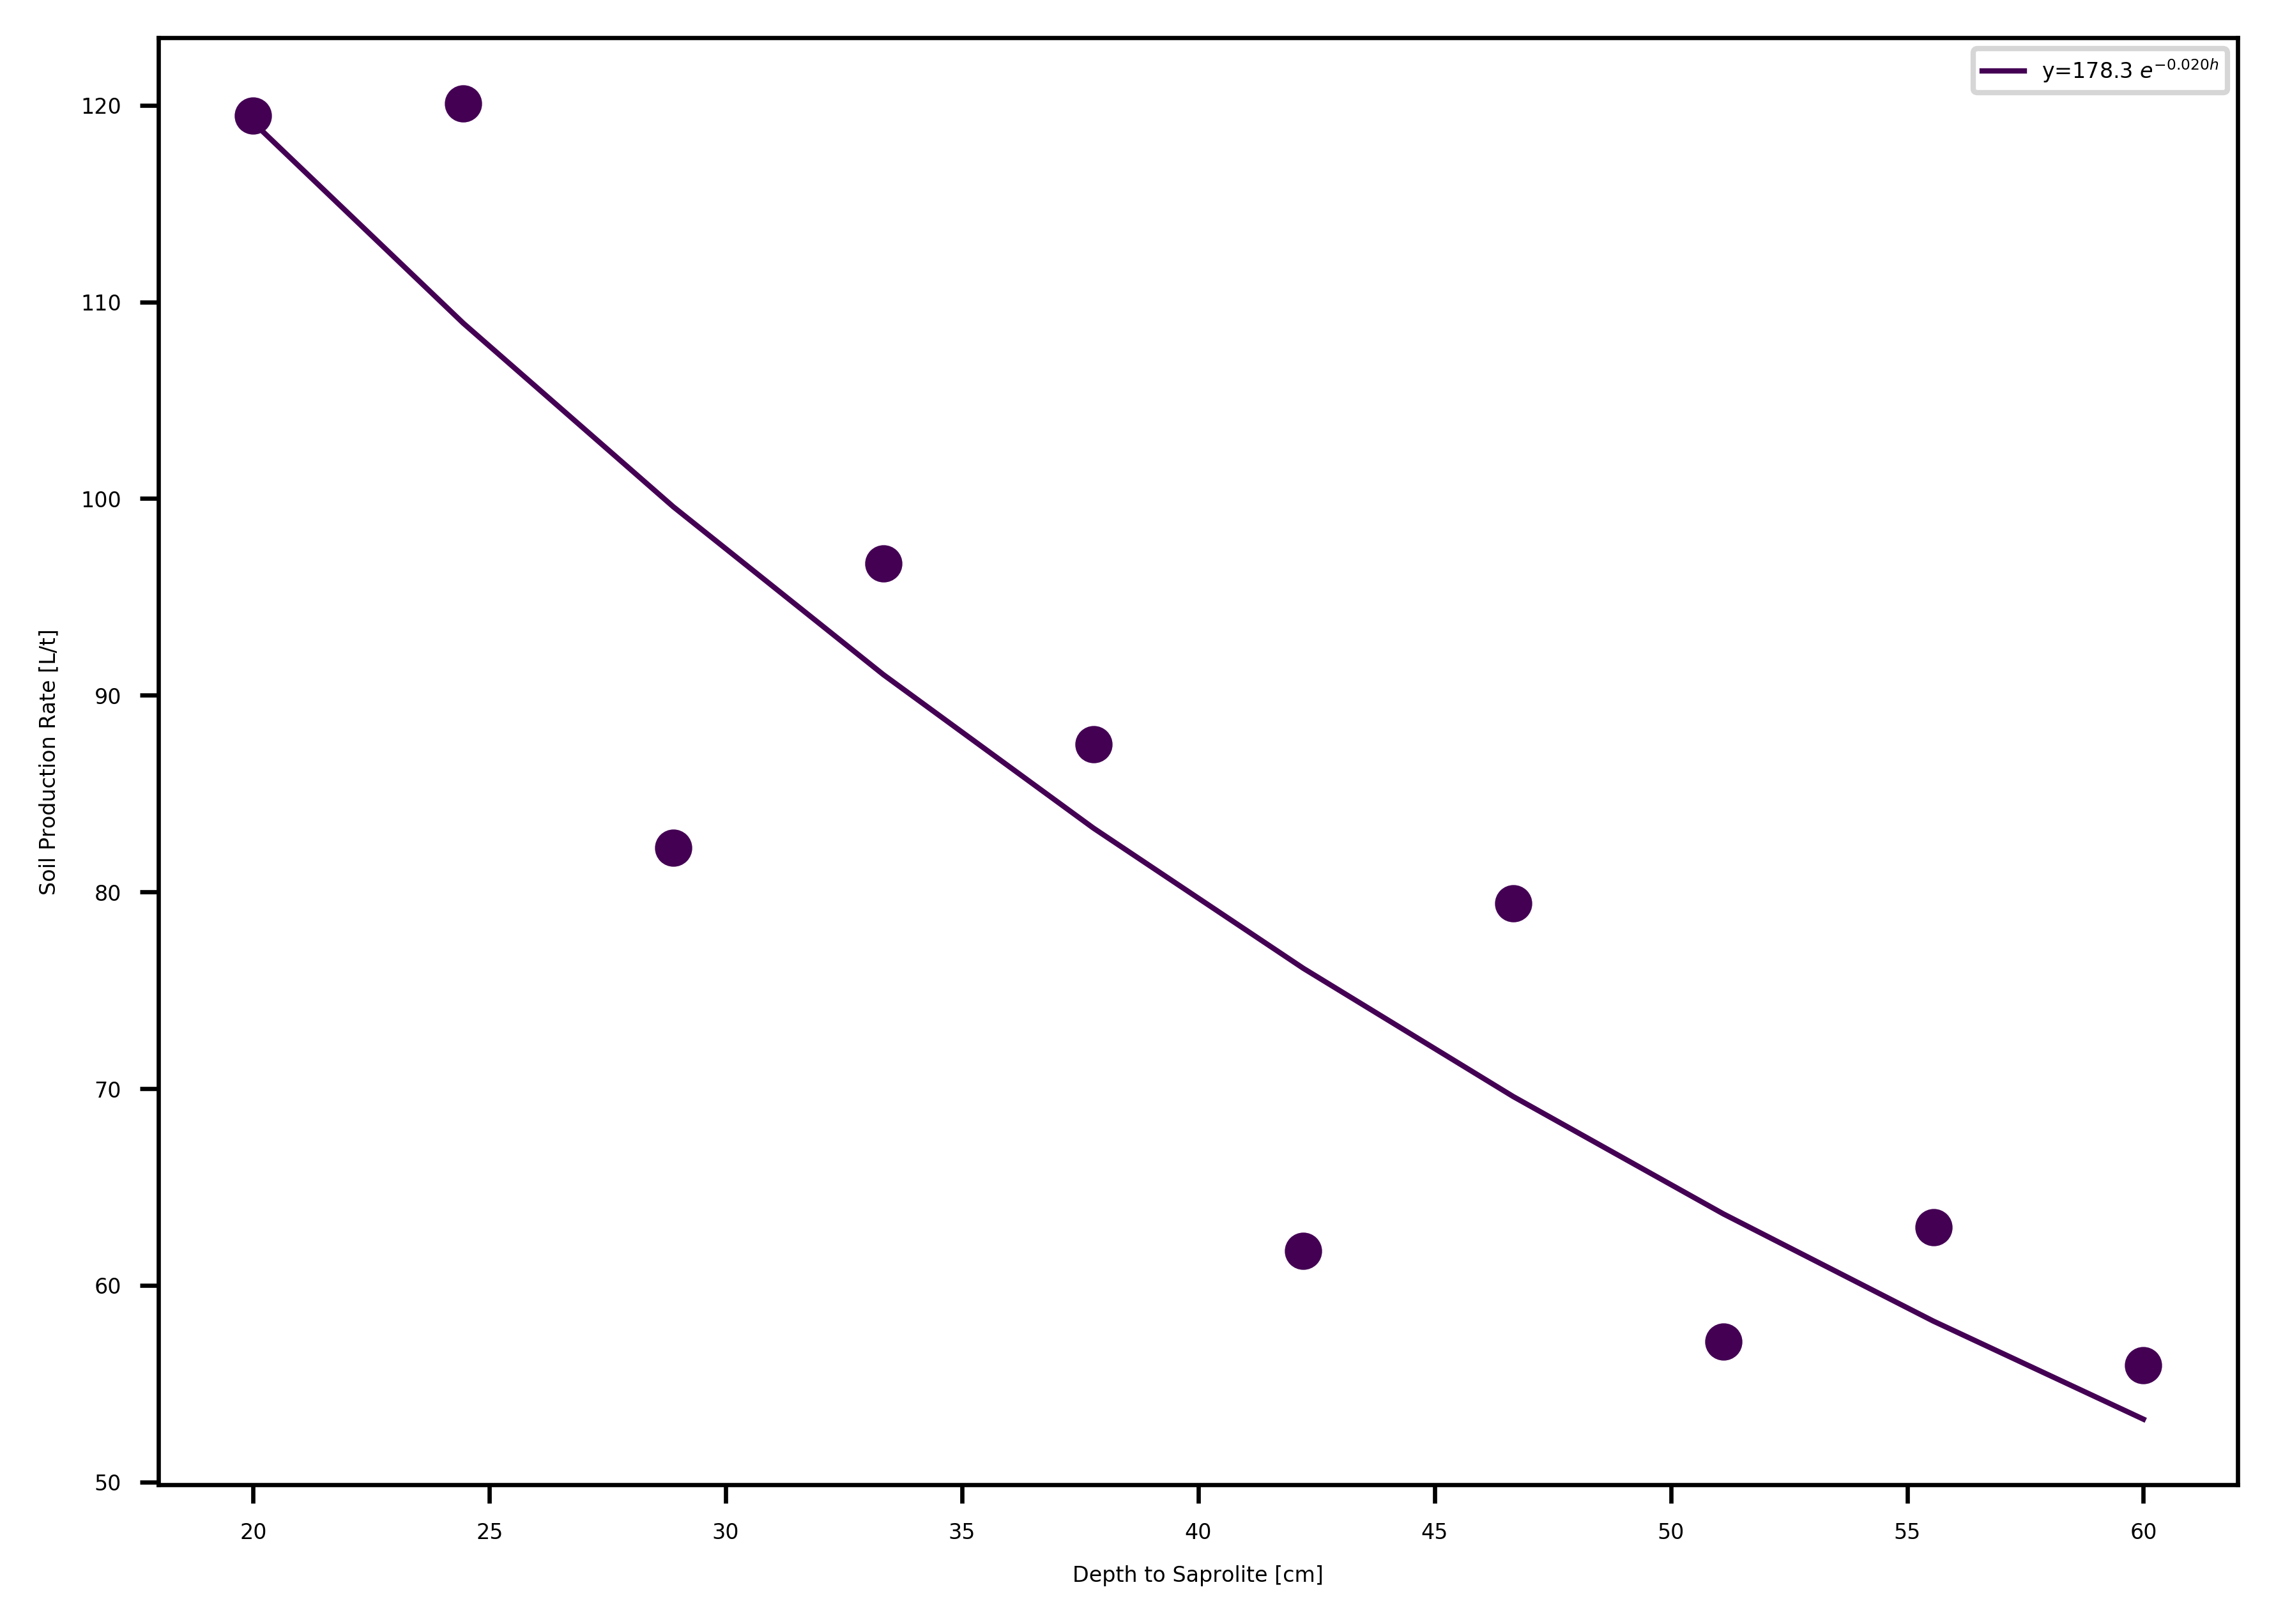

In [95]:
fig, ax = plt.subplots(figsize=(7,5))

ax.scatter(pits, EXP_initial_soil_production_rate)

ax.plot(pits, exponential_fit(pits, *EXP_steady_state_popt), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(EXP_steady_state_popt))

ax.set_xlabel('Depth to Saprolite [cm]')
ax.set_ylabel('Soil Production Rate [L/t]')
ax.legend()

#plt.savefig('exp_data_model.png')
plt.show()

In [698]:
def mc_soil_production_function(z):
    return 100 * np.exp(-0.003*z) 

In [699]:
MC_initial_soil_production_rate = mc_soil_production_function(pits)
noise = np.random.normal(0, 20, 10)
MC_initial_soil_production_rate = abs(MC_initial_soil_production_rate + noise)
MC_initial_soil_production_rate

array([ 95.46952074,  69.73988903, 106.97350822,  90.87659282,
        66.99046916,  64.11747333,  74.14237782,  54.87035411,
        75.12300819,  76.48179277])

MC_initial_soil_production_rate = abs(np.random.normal(loc=80, scale=20, size=10))
MC_initial_soil_production_rate

In [700]:
MC_steady_state_popt, ss_pcov = curve_fit(exponential_fit, pits, MC_initial_soil_production_rate, p0=(100,0.001))
print (MC_steady_state_popt)

[ 1.06892472e+02 -8.18689178e-03]


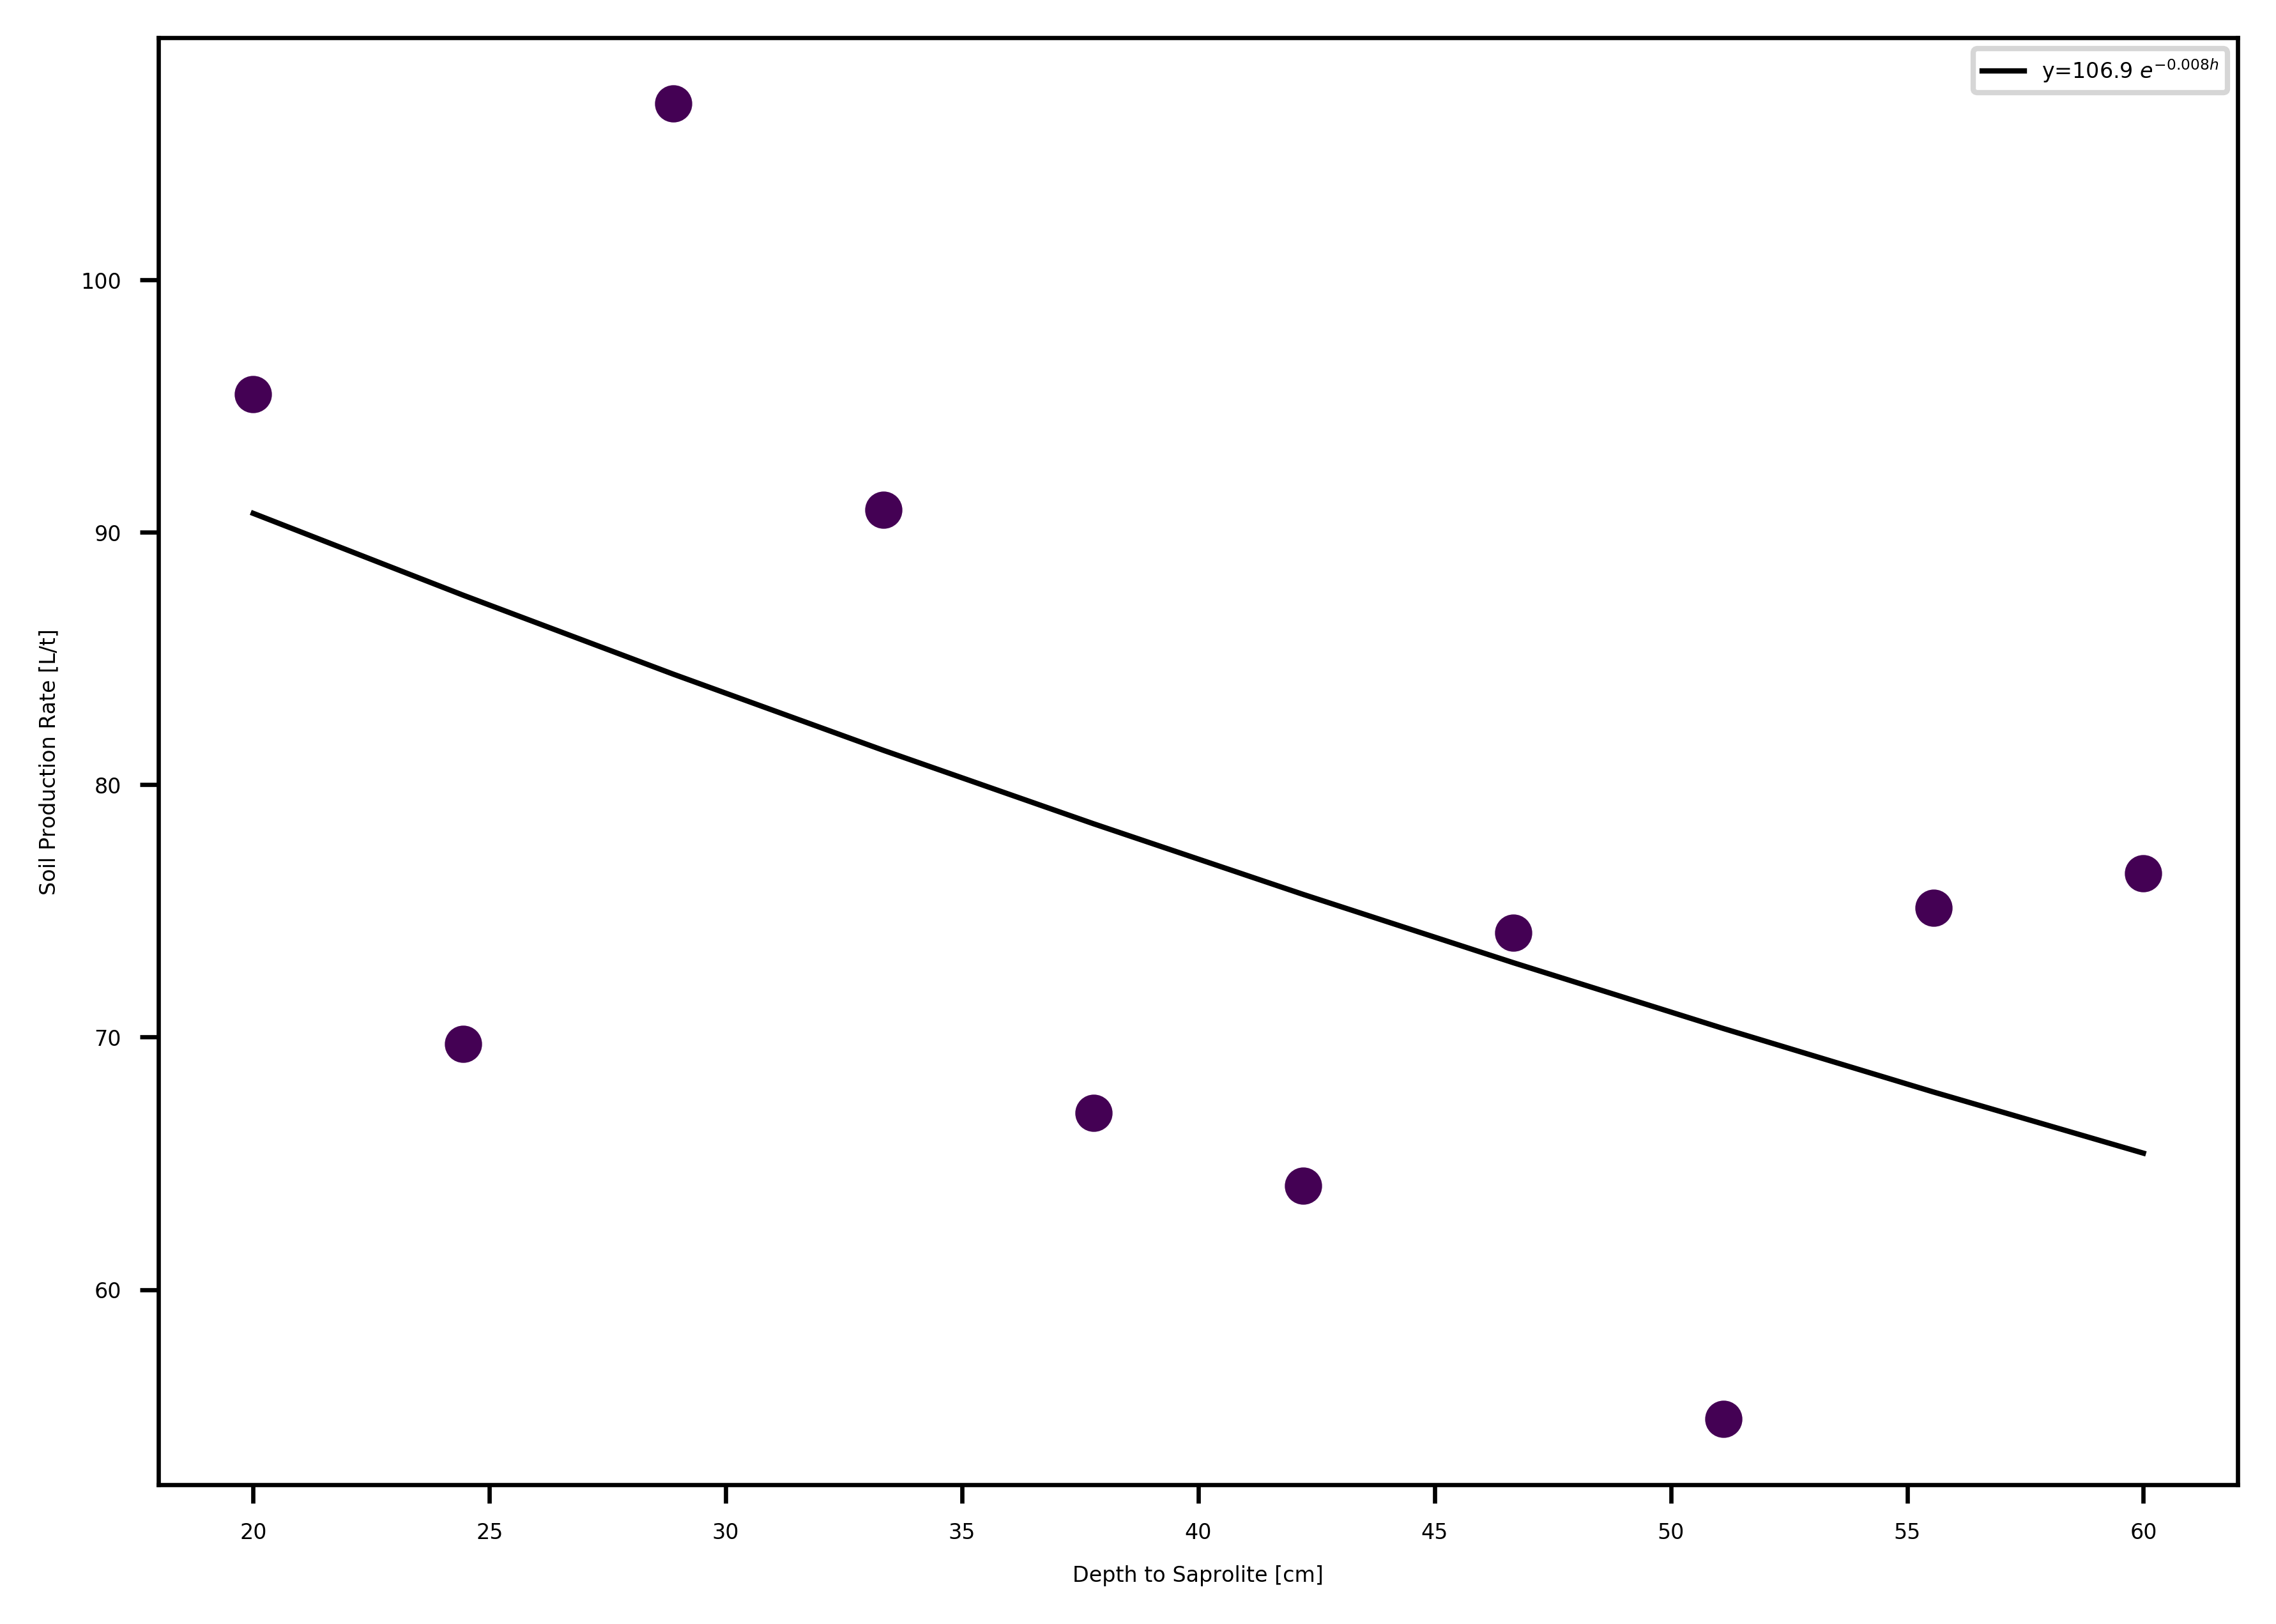

In [701]:
fig, ax = plt.subplots(figsize=(7,5))

ax.scatter(pits, MC_initial_soil_production_rate)
ax.plot(pits, exponential_fit(pits, *MC_steady_state_popt), color = 'k', 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(MC_steady_state_popt))

ax.set_xlabel('Depth to Saprolite [cm]')
ax.set_ylabel('Soil Production Rate [L/t]')
ax.legend()

plt.show()

Calculate the **PRE-EROSION** nuclide concentration for each $z$ from **equation 2**:
### $C_z = P_z  \left( \frac{1}{\lambda + \frac{\rho \in}{\Lambda}} \right)$

#### Constants:

$\lambda$ = $^{10}$Be decay constant = approximated as 0 for this simulation

$\in$ = Erosion rate = 40 [cm yr-1] for this simulation

In [702]:
def c_z(p,e):
    return p/((1.4*e)/165)

In [703]:
EXP_initial_10be_concentration = c_z(Pz_initial_pits, EXP_initial_soil_production_rate) # calculate for pre-erosion 'pits'

In [704]:
test_EXP_soil_production_from_cz = (165/1.4)*(Pz_initial_pits/EXP_initial_10be_concentration)

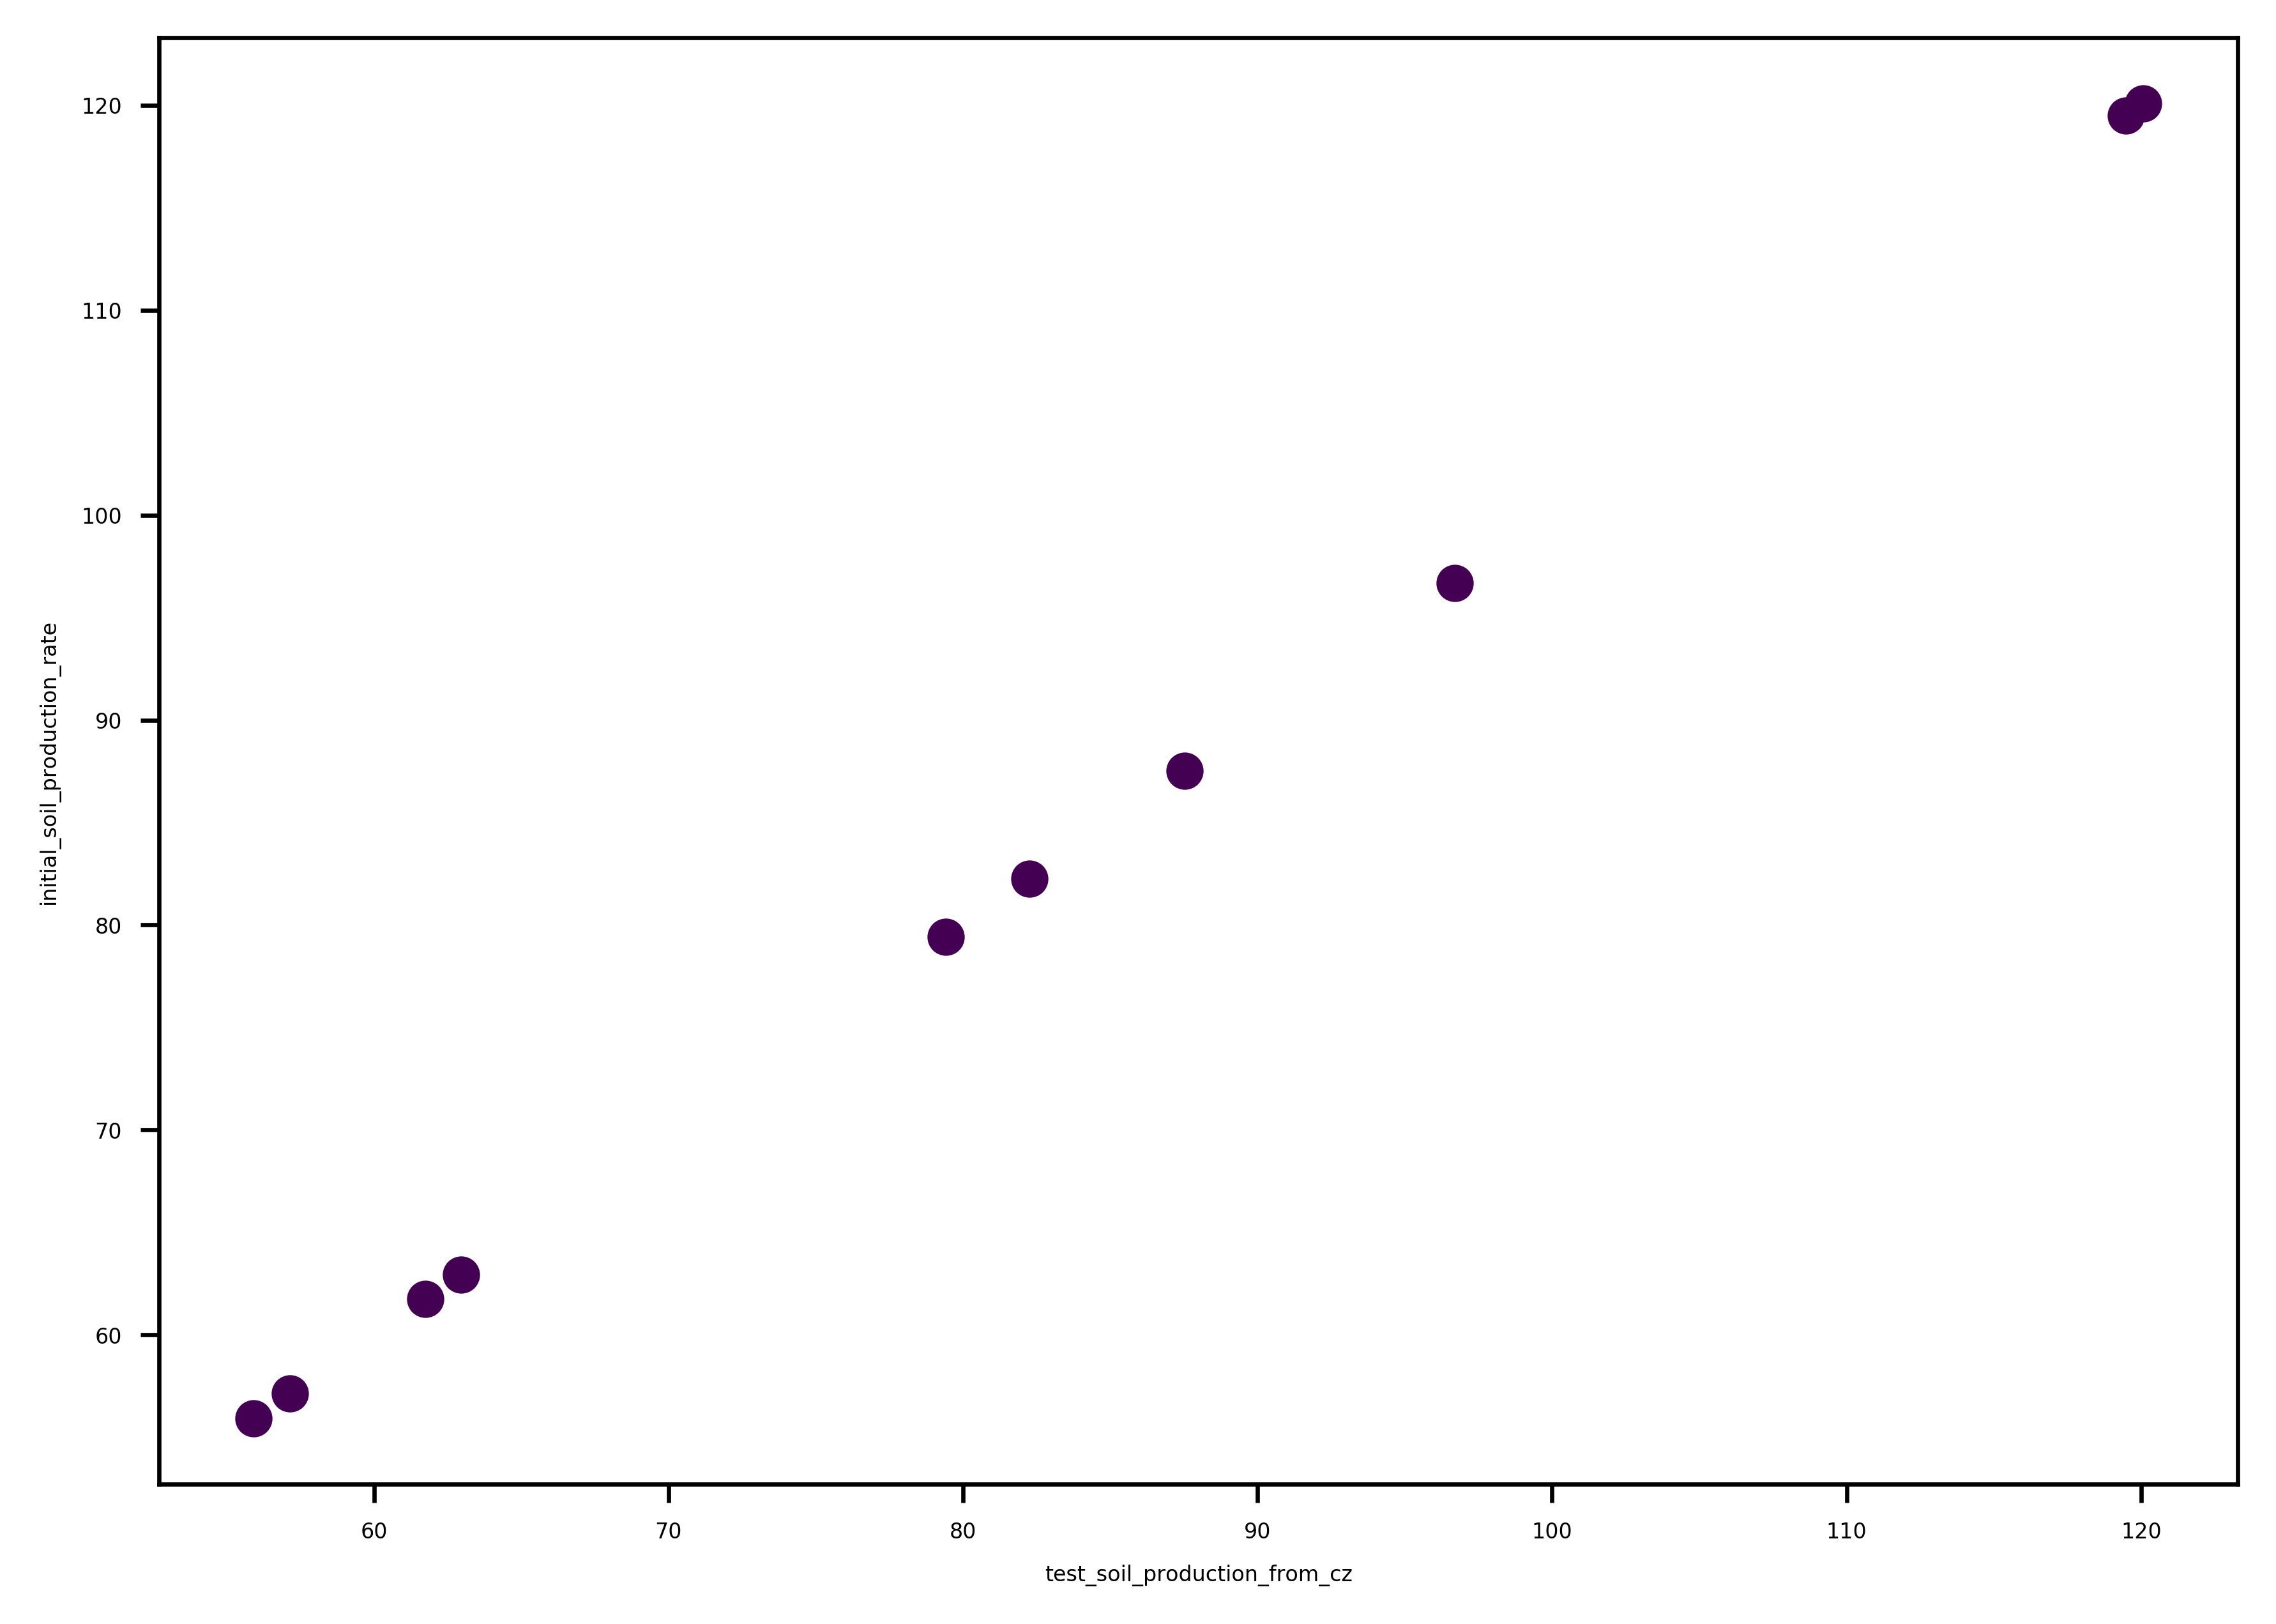

In [705]:
fig, ax = plt.subplots(figsize=(7,5))

ax.scatter(test_EXP_soil_production_from_cz, EXP_initial_soil_production_rate)

ax.set_xlabel('test_soil_production_from_cz')
ax.set_ylabel('initial_soil_production_rate')

plt.show()

In [706]:
MC_initial_10be_concentration = c_z(Pz_initial_pits, MC_initial_soil_production_rate) # calculate for pre-erosion 'pits'

In [707]:
test_MC_soil_production_from_cz = (165/1.4)*(Pz_initial_pits/MC_initial_10be_concentration)

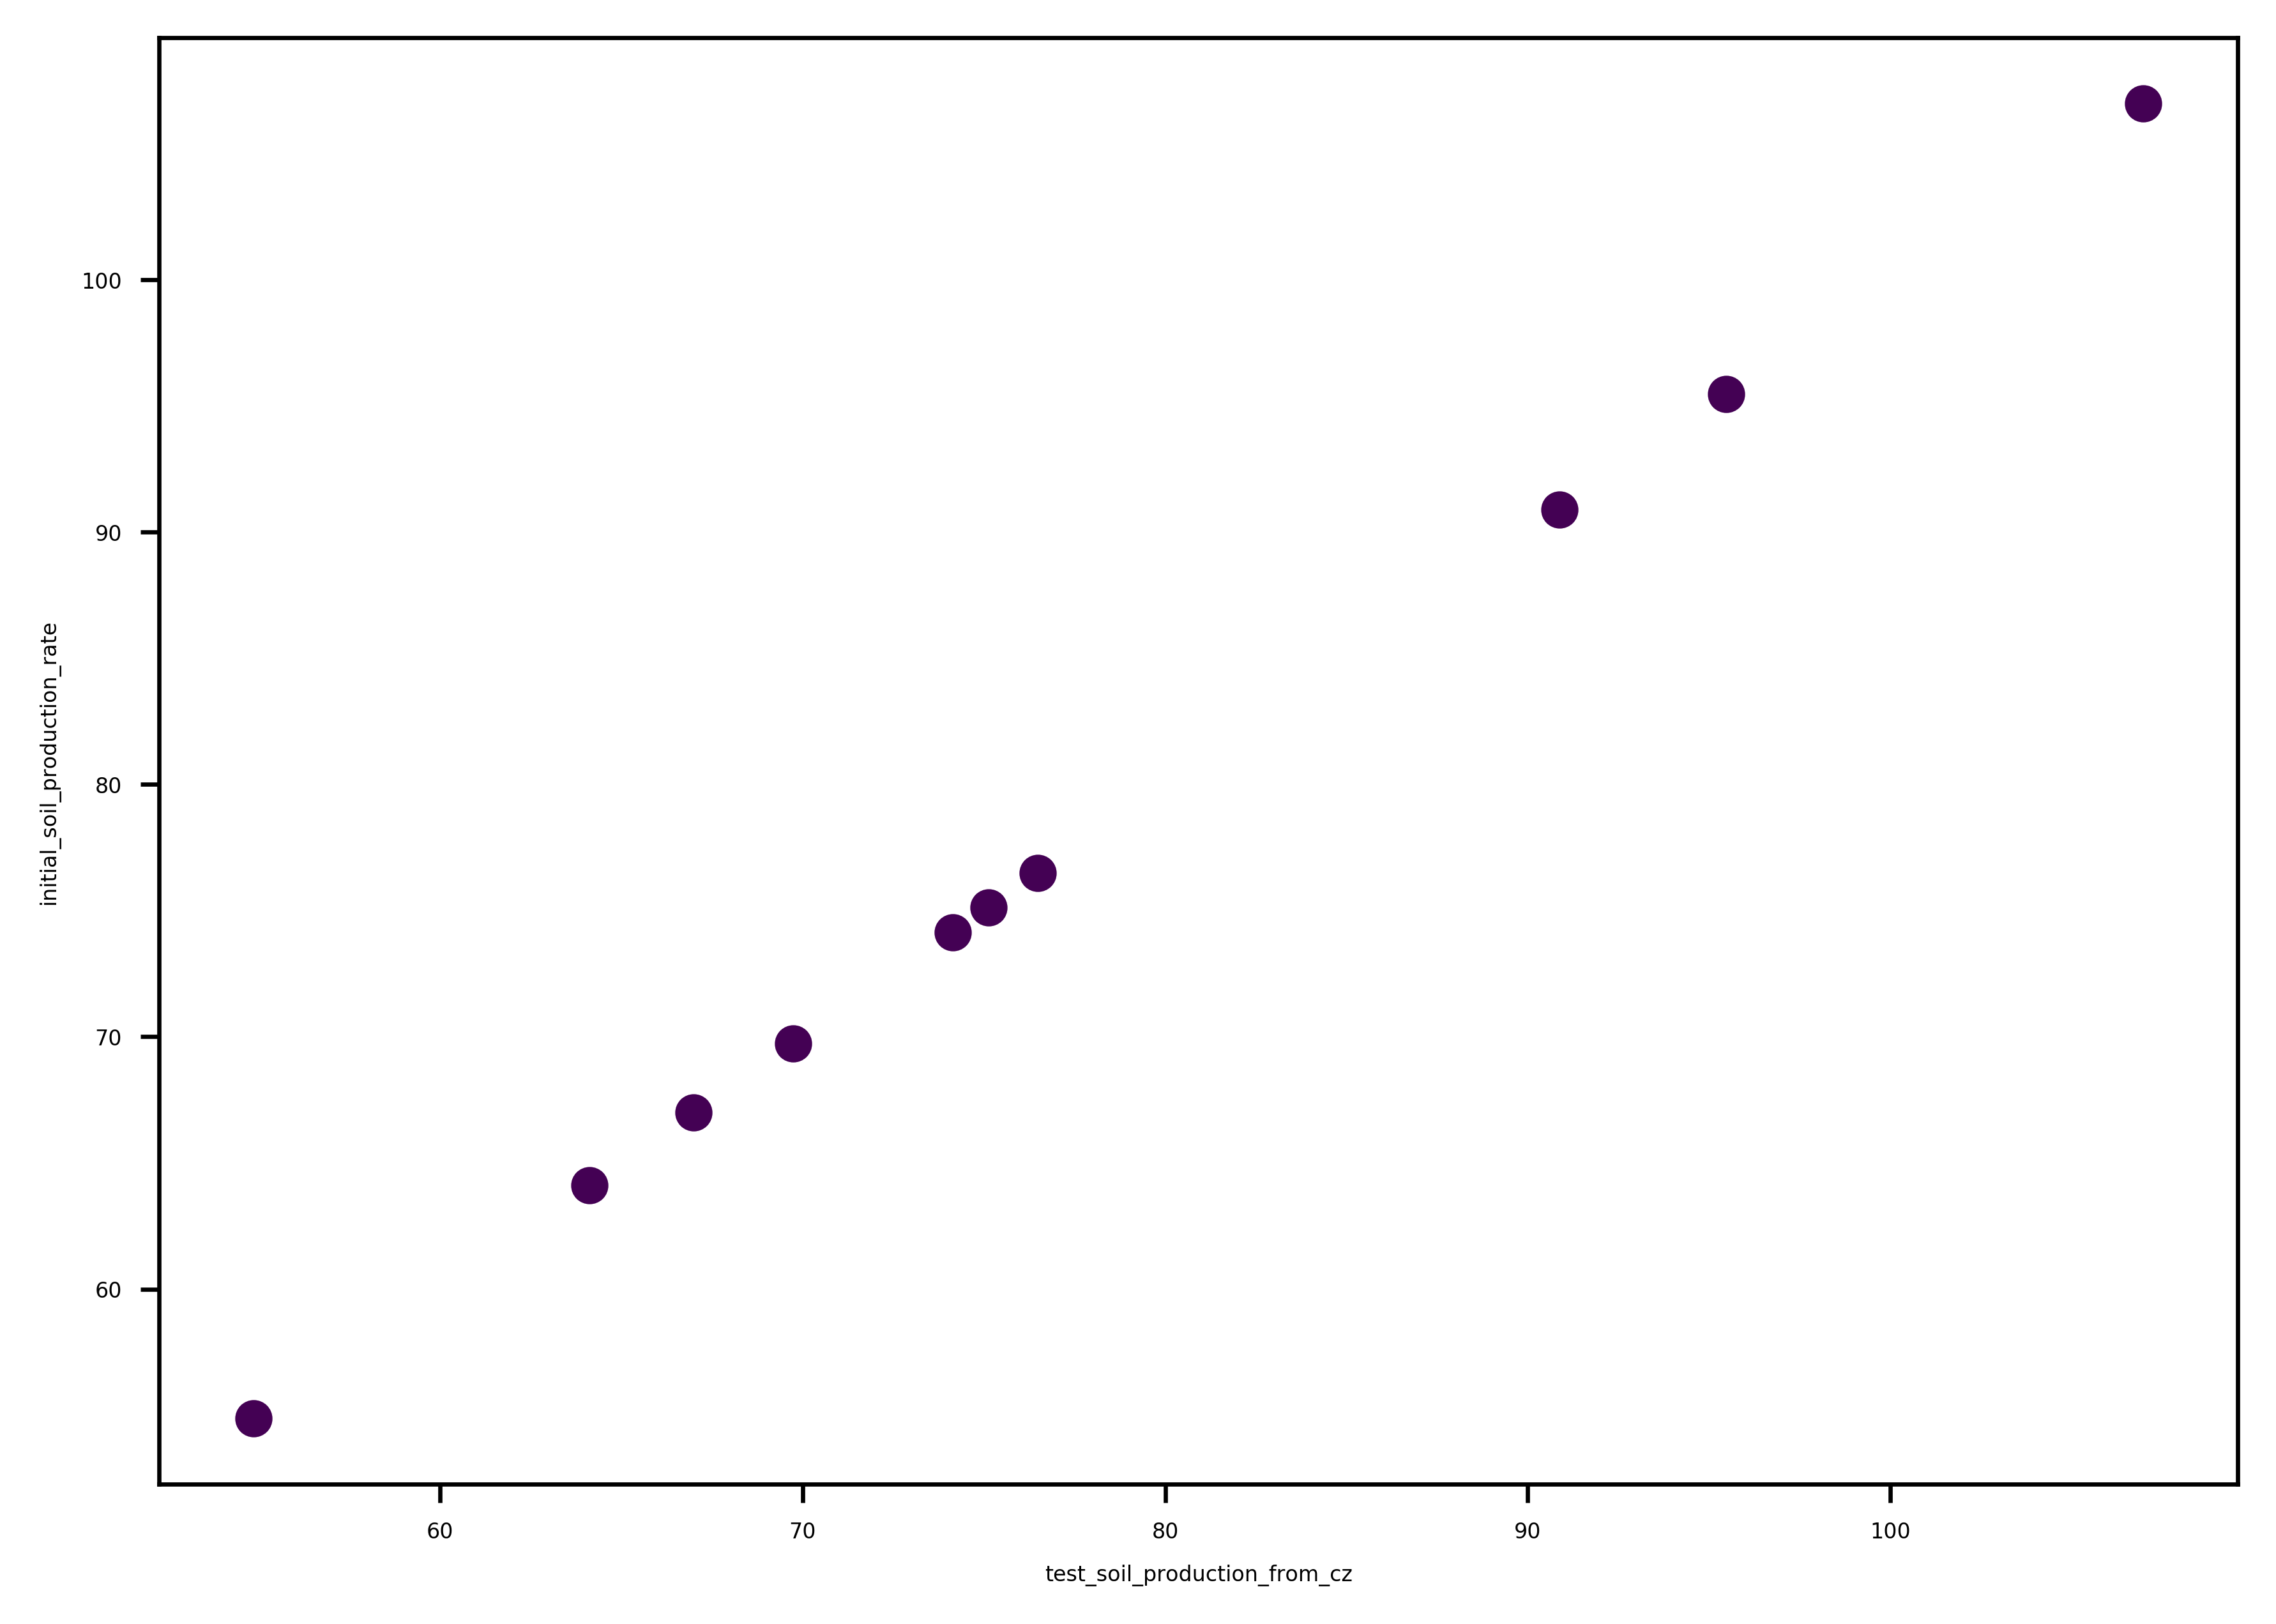

In [708]:
fig, ax = plt.subplots(figsize=(7,5))

ax.scatter(test_MC_soil_production_from_cz, MC_initial_soil_production_rate)

ax.set_xlabel('test_soil_production_from_cz')
ax.set_ylabel('initial_soil_production_rate')

plt.show()

## Part II
### Soil erosion pulses

Here, an array is created representing the percentage lost from each "pit"

In [709]:
EXP_max_percent = np.linspace(10,55, num=10)

In [760]:
MC_max_percent = np.linspace(55, 100, num=10)

In [761]:
#Exponential 

erode_at_intervals = []

for mp in EXP_max_percent:
    intervals = np.linspace(10, mp, num=10) 
    # generate linearly spaced numbers from 0 to each value in the array max_percent
    erode_at_intervals.append(intervals)
    # store in a list
    
    EXP_df_erode_at_intervals = pd.DataFrame()
    # create a dataframe
    EXP_df_erode_at_intervals['percent_of_initial_depth'] = erode_at_intervals
    # append lists to dataframe

EXP_df_erode_at_intervals = EXP_df_erode_at_intervals.T.reset_index(drop=True) 
# data transposed from rows to columns

EXP_df_erode_at_intervals = EXP_df_erode_at_intervals.add_prefix('')
# just converting the column names to str format

In [762]:
#Mean-Centered

erode_at_intervals = []

for mp in MC_max_percent:
    intervals = np.linspace(10, mp, num=10) 
    # generate linearly spaced numbers from 0 to each value in the array max_percent
    erode_at_intervals.append(intervals)
    # store in a list
    
    MC_df_erode_at_intervals = pd.DataFrame()
    # create a dataframe
    MC_df_erode_at_intervals['percent_of_initial_depth'] = erode_at_intervals
    # append lists to dataframe

MC_df_erode_at_intervals = MC_df_erode_at_intervals.T.reset_index(drop=True) 
# data transposed from rows to columns

MC_df_erode_at_intervals = MC_df_erode_at_intervals.add_prefix('')
# just converting the column names to str format

Here, the dataframe contents are expanded into unique rows

In [763]:
#Exponential 

col_lst = EXP_df_erode_at_intervals.columns.to_list() 
# column names to list
EXP_df_erode_at_intervals = explode(EXP_df_erode_at_intervals, lst_cols = col_lst)
# expand contents to unique rows

In [764]:
# Exponential

EXP_df_erode_at_intervals = EXP_df_erode_at_intervals.round(decimals=1)

In [765]:
# Exponential

df_mul = EXP_df_erode_at_intervals.multiply(pits*0.01, axis=0)
df_sub = df_mul.sub(pits, axis=0)
EXP_df_stripped_soil_pits = df_sub.abs()
EXP_df_stripped_soil_pits = EXP_df_stripped_soil_pits.round(1)

In [766]:
# Exponential

max_p = (EXP_max_percent).astype(int)

EXP_df_stripped_soil_pits.columns = max_p
# rename dataframe columns from the list

EXP_df_stripped_soil_pits = EXP_df_stripped_soil_pits.add_prefix('Max Loss ')
EXP_df_stripped_soil_pits = EXP_df_stripped_soil_pits.add_suffix('%')

In [767]:
#EXP_df_stripped_soil_pits # eroded depth-to-saprolite values

In [768]:
# Exponential

percent_loss_labels = EXP_df_stripped_soil_pits.columns.to_list()
#percent_loss_labels

In [769]:
#Mean-centered 

col_lst = MC_df_erode_at_intervals.columns.to_list() 
# column names to list
MC_df_erode_at_intervals = explode(MC_df_erode_at_intervals, lst_cols = col_lst)
# expand contents to unique rows

In [770]:
#Mean-centered

MC_df_erode_at_intervals = MC_df_erode_at_intervals.round(decimals=1)

In [771]:
# Mean-centered

df_mul = MC_df_erode_at_intervals.multiply(pits*0.01, axis=0)
df_sub = df_mul.sub(pits, axis=0)
MC_df_stripped_soil_pits = df_sub.abs()
MC_df_stripped_soil_pits = MC_df_stripped_soil_pits.round(1)

In [772]:
# Mean-centered

max_p = (MC_max_percent).astype(int)

MC_df_stripped_soil_pits.columns = max_p
# rename dataframe columns from the list

MC_df_stripped_soil_pits = MC_df_stripped_soil_pits.add_prefix('Max Loss ')
MC_df_stripped_soil_pits = MC_df_stripped_soil_pits.add_suffix('%')

In [773]:
pit_list = np.arange(1, len(pits)+1).tolist()

In [774]:
append_prefix = 'Pit No '
pit_number = [append_prefix + str(s) for s in pit_list]

In [775]:
cbar_props = {'fraction' : 0.05, 'orientation' : 'horizontal', 'pad' : 0.02}

In [776]:
#rcParams.keys

In [777]:
Pz_EXP = EXP_df_stripped_soil_pits.apply(p_rate)

Pz_MC = MC_df_stripped_soil_pits.apply(p_rate)

Visualize the results

In [778]:
#Pz_EXP

Here, the 10be concentrations for the pre-eroded pits is added to the df Pz

In [779]:
Pz_EXP.insert(0, '10be_concentration', EXP_initial_10be_concentration)

Pz_MC.insert(0, '10be_concentration', MC_initial_10be_concentration)

In [780]:
EXP_truncated_SP_rate = (165/1.4) * Pz_EXP.div(Pz_EXP['10be_concentration'], axis=0) 
# calculation
EXP_truncated_SP_rate = EXP_truncated_SP_rate.drop(columns='10be_concentration') 
# drop col

In [781]:
MC_truncated_SP_rate = (165/1.4) * Pz_MC.div(Pz_MC['10be_concentration'], axis=0) 
# calculation
MC_truncated_SP_rate = MC_truncated_SP_rate.drop(columns='10be_concentration') 
# drop col

### Visualize the results

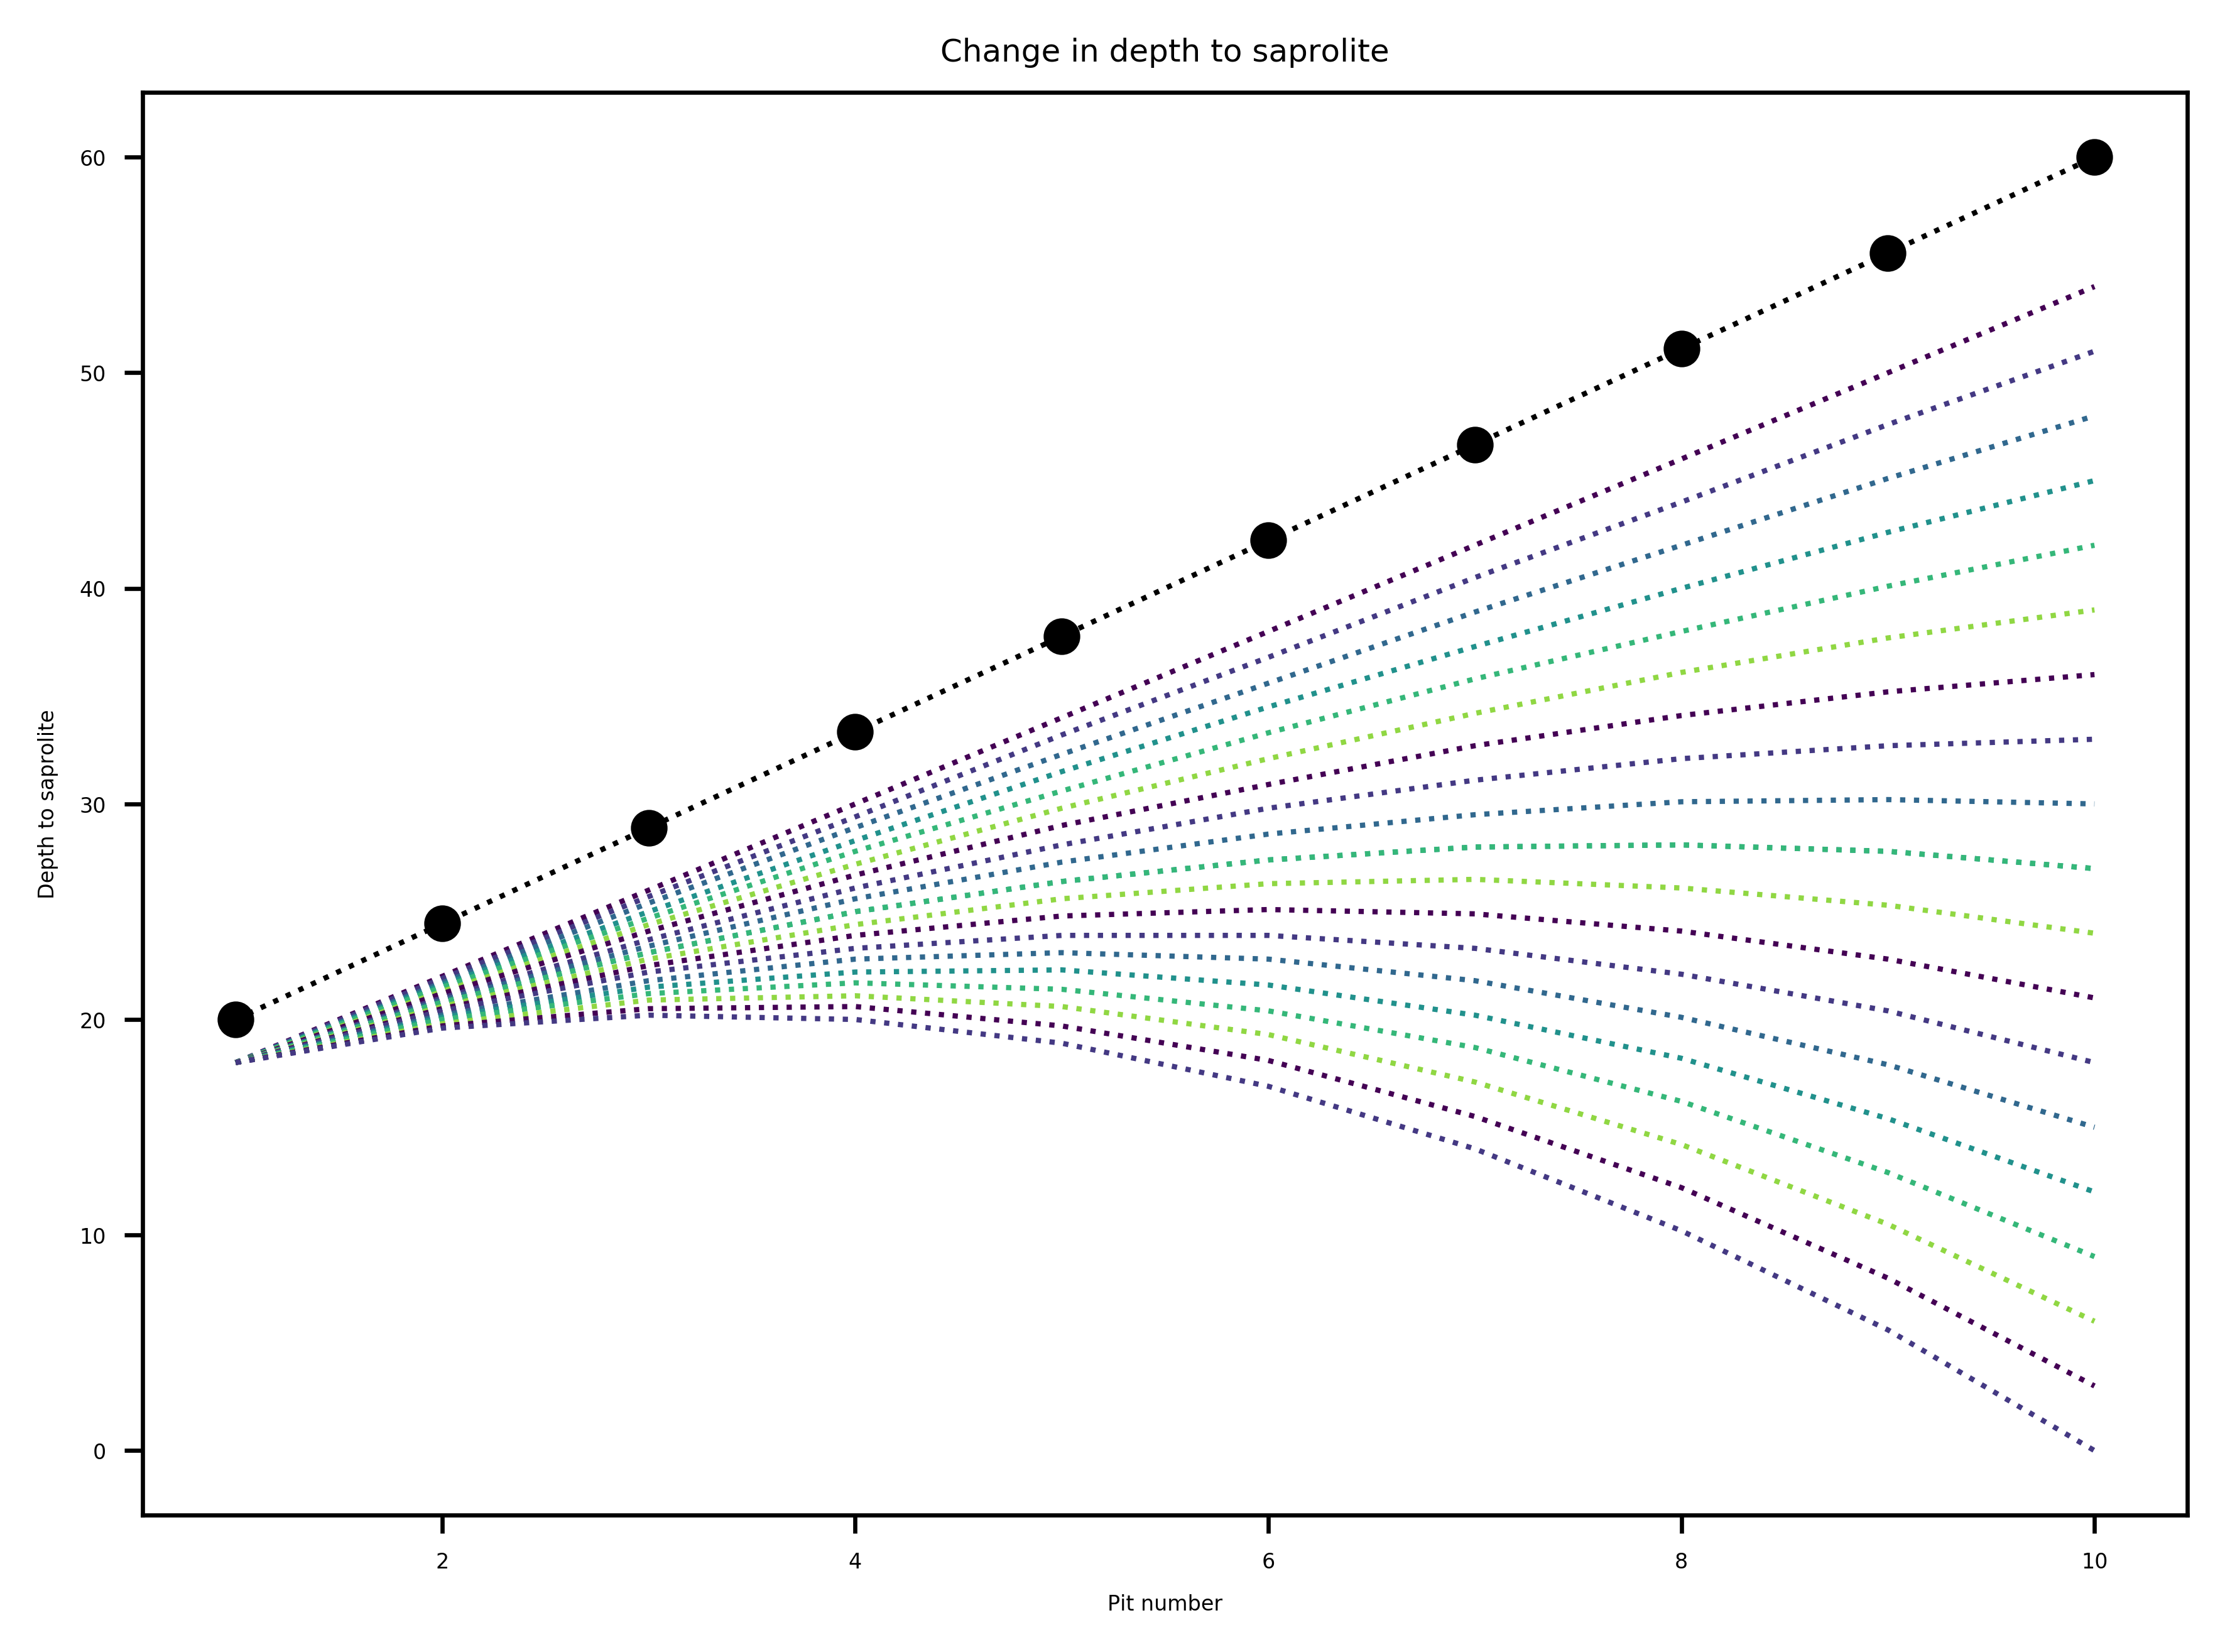

In [782]:
fig, ax = plt.subplots(figsize=(7, 5))

#plt.rc('axes', 
       #prop_cycle=(cycler('color', new_colors)))

# Left plot - soil pit number vs. soil mantle thickness

ax.plot(pit_list, pits, ':ko', label='Pre-erosion')

for i in EXP_df_stripped_soil_pits.columns:
    ax.plot(pit_list, EXP_df_stripped_soil_pits[i], ':')


for i in MC_df_stripped_soil_pits.columns:
    ax.plot(pit_list, MC_df_stripped_soil_pits[i], ':')
    

ax.set_xlabel("Pit number")
ax.set_ylabel("Depth to saprolite")

ax.set_title('Change in depth to saprolite')

plt.show()

In [783]:
#rcParams.keys()

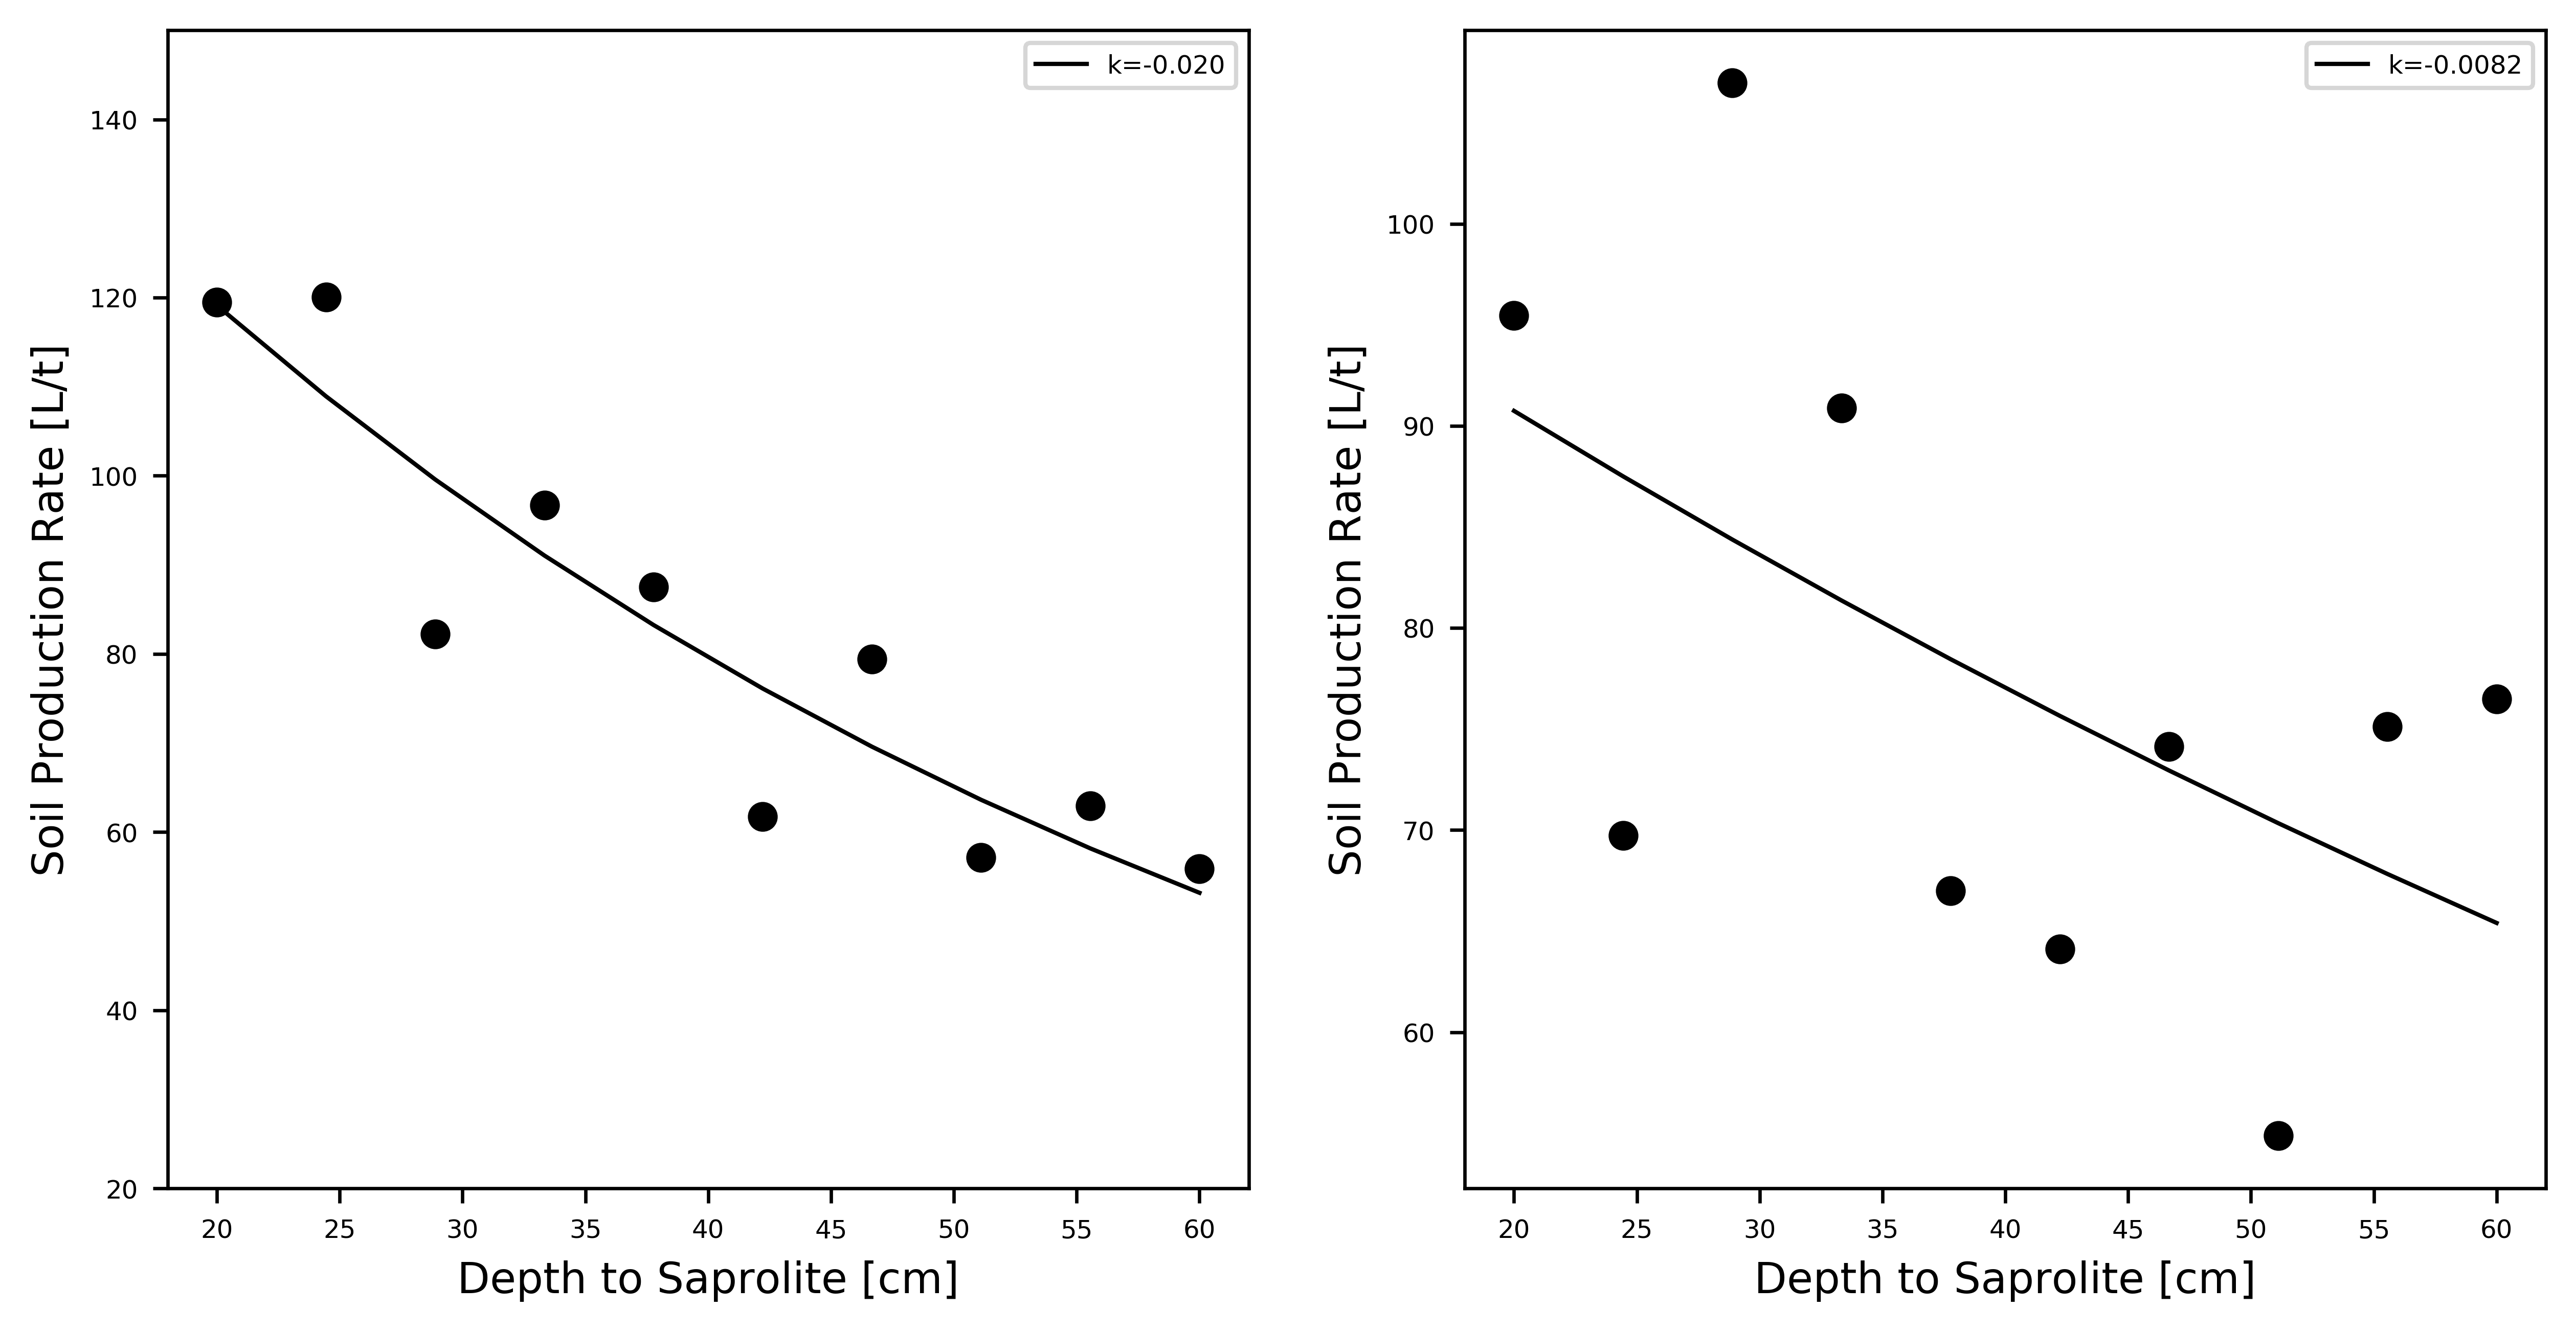

In [784]:
# Text, labels, lines
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['lines.linewidth'] = 1


fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot(121) # Exponential SP:SD pre-erosion
ax3 = plt.subplot(122) # Mean Centered SP:SD pre-erosion

# Exponential SP:SD pre-erosion

ax1.scatter(pits, EXP_initial_soil_production_rate, color='k') # pre-erosion

ax1.plot(pits, exponential_fit(pits, *EXP_steady_state_popt), color='k', # spf regression
        label='k=%5.3f' %(EXP_steady_state_popt[1]))

# ax1 params

ax1.set_ylim(20,150)
ax1.set_ylabel('Soil Production Rate [L/t]')
ax1.set_xlabel('Depth to Saprolite [cm]')
ax1.legend()


# Mean-centered SP:SD pre-erosion

ax3.scatter(pits, MC_initial_soil_production_rate, color='k') # pre-erosion

ax3.plot(pits, exponential_fit(pits, *MC_steady_state_popt), color='k', # spf regression
        label='k=%5.4f' %(MC_steady_state_popt[1]))

# ax3 params

#ax3.set_ylim(20,150)
ax3.set_xlabel('Depth to Saprolite [cm]')
ax3.set_ylabel('Soil Production Rate [L/t]')
ax3.legend()

#plt.savefig('both_models_data_fit.png')
plt.show()

In [785]:
n = 6
new_colors = [plt.get_cmap('viridis')(1. * i/n) for i in range(n)]

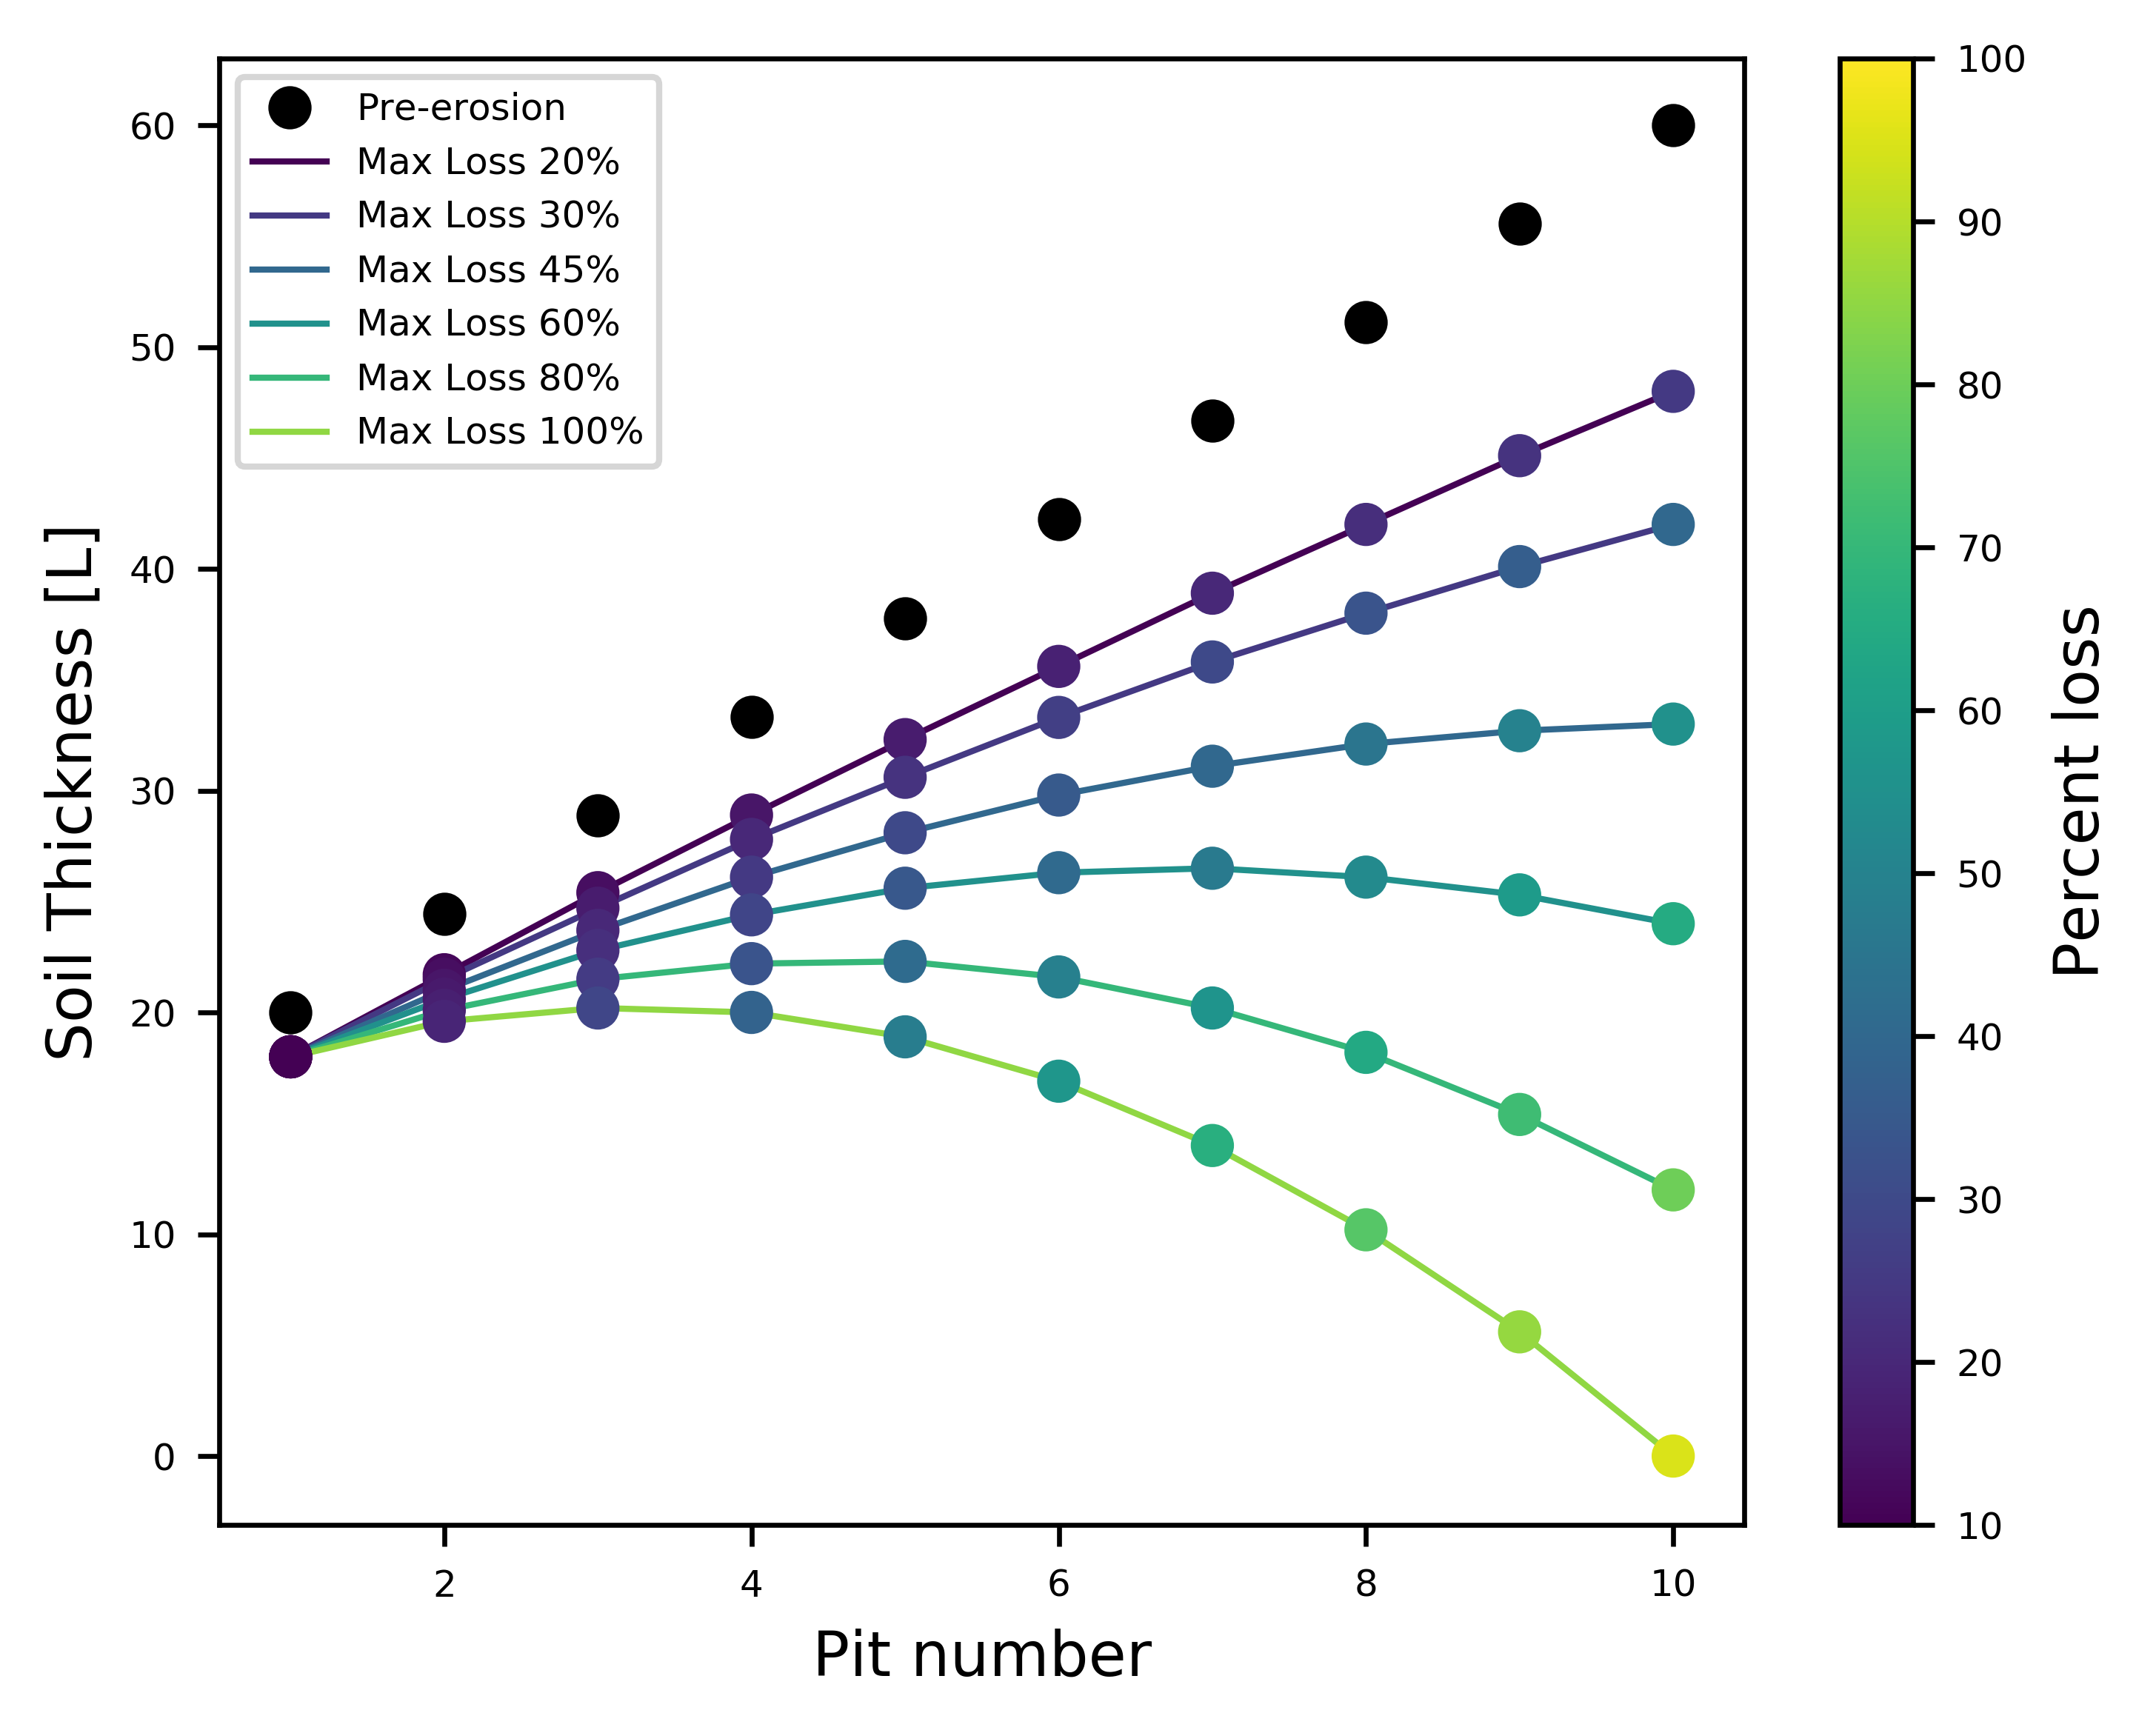

In [786]:
exp_min, exp_max = 10, 100
norm_exp = plt.Normalize(exp_min, exp_max)

fig, ax = plt.subplots(figsize=(5,4))

plt.rc('axes', 
       prop_cycle=(cycler('color', new_colors)))


# Exponential erosion pulse scenario

ax.plot(pit_list, pits, 'ko', label='Pre-erosion')

ax.plot(pit_list, EXP_df_stripped_soil_pits['Max Loss 20%'],  label='Max Loss 20%', zorder=1)
ax.plot(pit_list, EXP_df_stripped_soil_pits['Max Loss 30%'], label='Max Loss 30%', zorder=1)
ax.plot(pit_list, EXP_df_stripped_soil_pits['Max Loss 45%'], label='Max Loss 45%', zorder=1)

exp = ax.scatter(pit_list, EXP_df_stripped_soil_pits['Max Loss 20%'], 
                  c=EXP_df_erode_at_intervals['3'], norm=norm_exp, zorder=2)

ax.scatter(pit_list, EXP_df_stripped_soil_pits['Max Loss 30%'], 
            c=EXP_df_erode_at_intervals['6'], norm=norm_exp, zorder=2)

ax.scatter(pit_list, EXP_df_stripped_soil_pits['Max Loss 45%'], 
            c=EXP_df_erode_at_intervals['9'], norm=norm_exp, zorder=2)

ax.plot(pit_list, MC_df_stripped_soil_pits['Max Loss 60%'], label='Max Loss 60%', zorder=1)
ax.plot(pit_list, MC_df_stripped_soil_pits['Max Loss 80%'], label='Max Loss 80%', zorder=1)
ax.plot(pit_list, MC_df_stripped_soil_pits['Max Loss 100%'], label='Max Loss 100%', zorder=1)

ax.scatter(pit_list, MC_df_stripped_soil_pits['Max Loss 60%'], 
                 c=MC_df_erode_at_intervals['2'], norm=norm_exp, zorder=2)

ax.scatter(pit_list, MC_df_stripped_soil_pits['Max Loss 80%'],
            c=MC_df_erode_at_intervals['5'], norm=norm_exp, zorder=2)

ax.scatter(pit_list, MC_df_stripped_soil_pits['Max Loss 100%'], 
            c=MC_df_erode_at_intervals['8'], norm=norm_exp, zorder=2)

# Colorbar  ------------------------------------------

fig.colorbar(exp, ax=ax, orientation='vertical', 
              label='Percent loss')

# params  ------------------------------------------

ax.set_xlabel('Pit number')
ax.set_ylabel('Soil Thickness [L]')
ax.legend()

plt.tight_layout()
#plt.savefig('eroded_depths_all_models.png')
plt.show()

## PART III - Exponential sp/sd
### Regression to determine production function coefficients

Curve fitting is used to determine the coefficients of an exponential regression to the modeled data:

In [787]:
EXP_result = [] # initialize lists
EXP_label = []
EXP_covariance = []

for d in EXP_df_stripped_soil_pits.columns:
    xdata = EXP_df_stripped_soil_pits[d] # loop through depths
    ydata = EXP_truncated_SP_rate.loc[:,EXP_truncated_SP_rate.columns.str.startswith(d)].squeeze() 
    # soil production rates corresponding to the depth array
        
    popt, pcov = curve_fit(exponential_fit, xdata, ydata, p0=(100,0.001))
    # find parameters for the exponential regression 
    
    EXP_result.append(popt) # store results
    EXP_label.append(d) # store labels
    EXP_covariance.append(pcov)

Store the fit parameters in a dictionary.

In [788]:
EXP_spf_dict = dict(zip(EXP_label, EXP_result))
EXP_spf_dict

{'Max Loss 10%': array([ 1.78044328e+02, -2.14119179e-02]),
 'Max Loss 15%': array([ 1.81974778e+02, -2.24706505e-02]),
 'Max Loss 20%': array([ 1.86915751e+02, -2.37664309e-02]),
 'Max Loss 25%': array([ 1.92794564e+02, -2.52809038e-02]),
 'Max Loss 30%': array([ 2.00375626e+02, -2.71513350e-02]),
 'Max Loss 35%': array([ 2.10049532e+02, -2.94597633e-02]),
 'Max Loss 40%': array([ 2.2280425e+02, -3.2357110e-02]),
 'Max Loss 45%': array([ 2.40100130e+02, -3.61188405e-02]),
 'Max Loss 50%': array([ 2.64337809e+02, -4.10010422e-02]),
 'Max Loss 55%': array([ 2.96609338e+02, -4.71024867e-02])}

Maximum percent loss in truncated pits and corresponding exponential coefficient of the regression are stored in unique lists

In [789]:
EXP_best_fit_expon_val = [elem[1] for elem in EXP_spf_dict.values()] # list containing best fit exponent values
EXP_max_loss_in_percentage = list(EXP_spf_dict.keys()) # list containing the percent loss

In [790]:
print ("mean :", np.mean(EXP_best_fit_expon_val))
print ("standard deviation:", np.std(EXP_best_fit_expon_val))
print ("range:", max(EXP_best_fit_expon_val), "to", min(EXP_best_fit_expon_val))

mean : -0.030612048090373566
standard deviation: 0.008079284543055253
range: -0.021411917941530405 to -0.0471024867218772


In [791]:
#EXP_max_loss_in_percentage

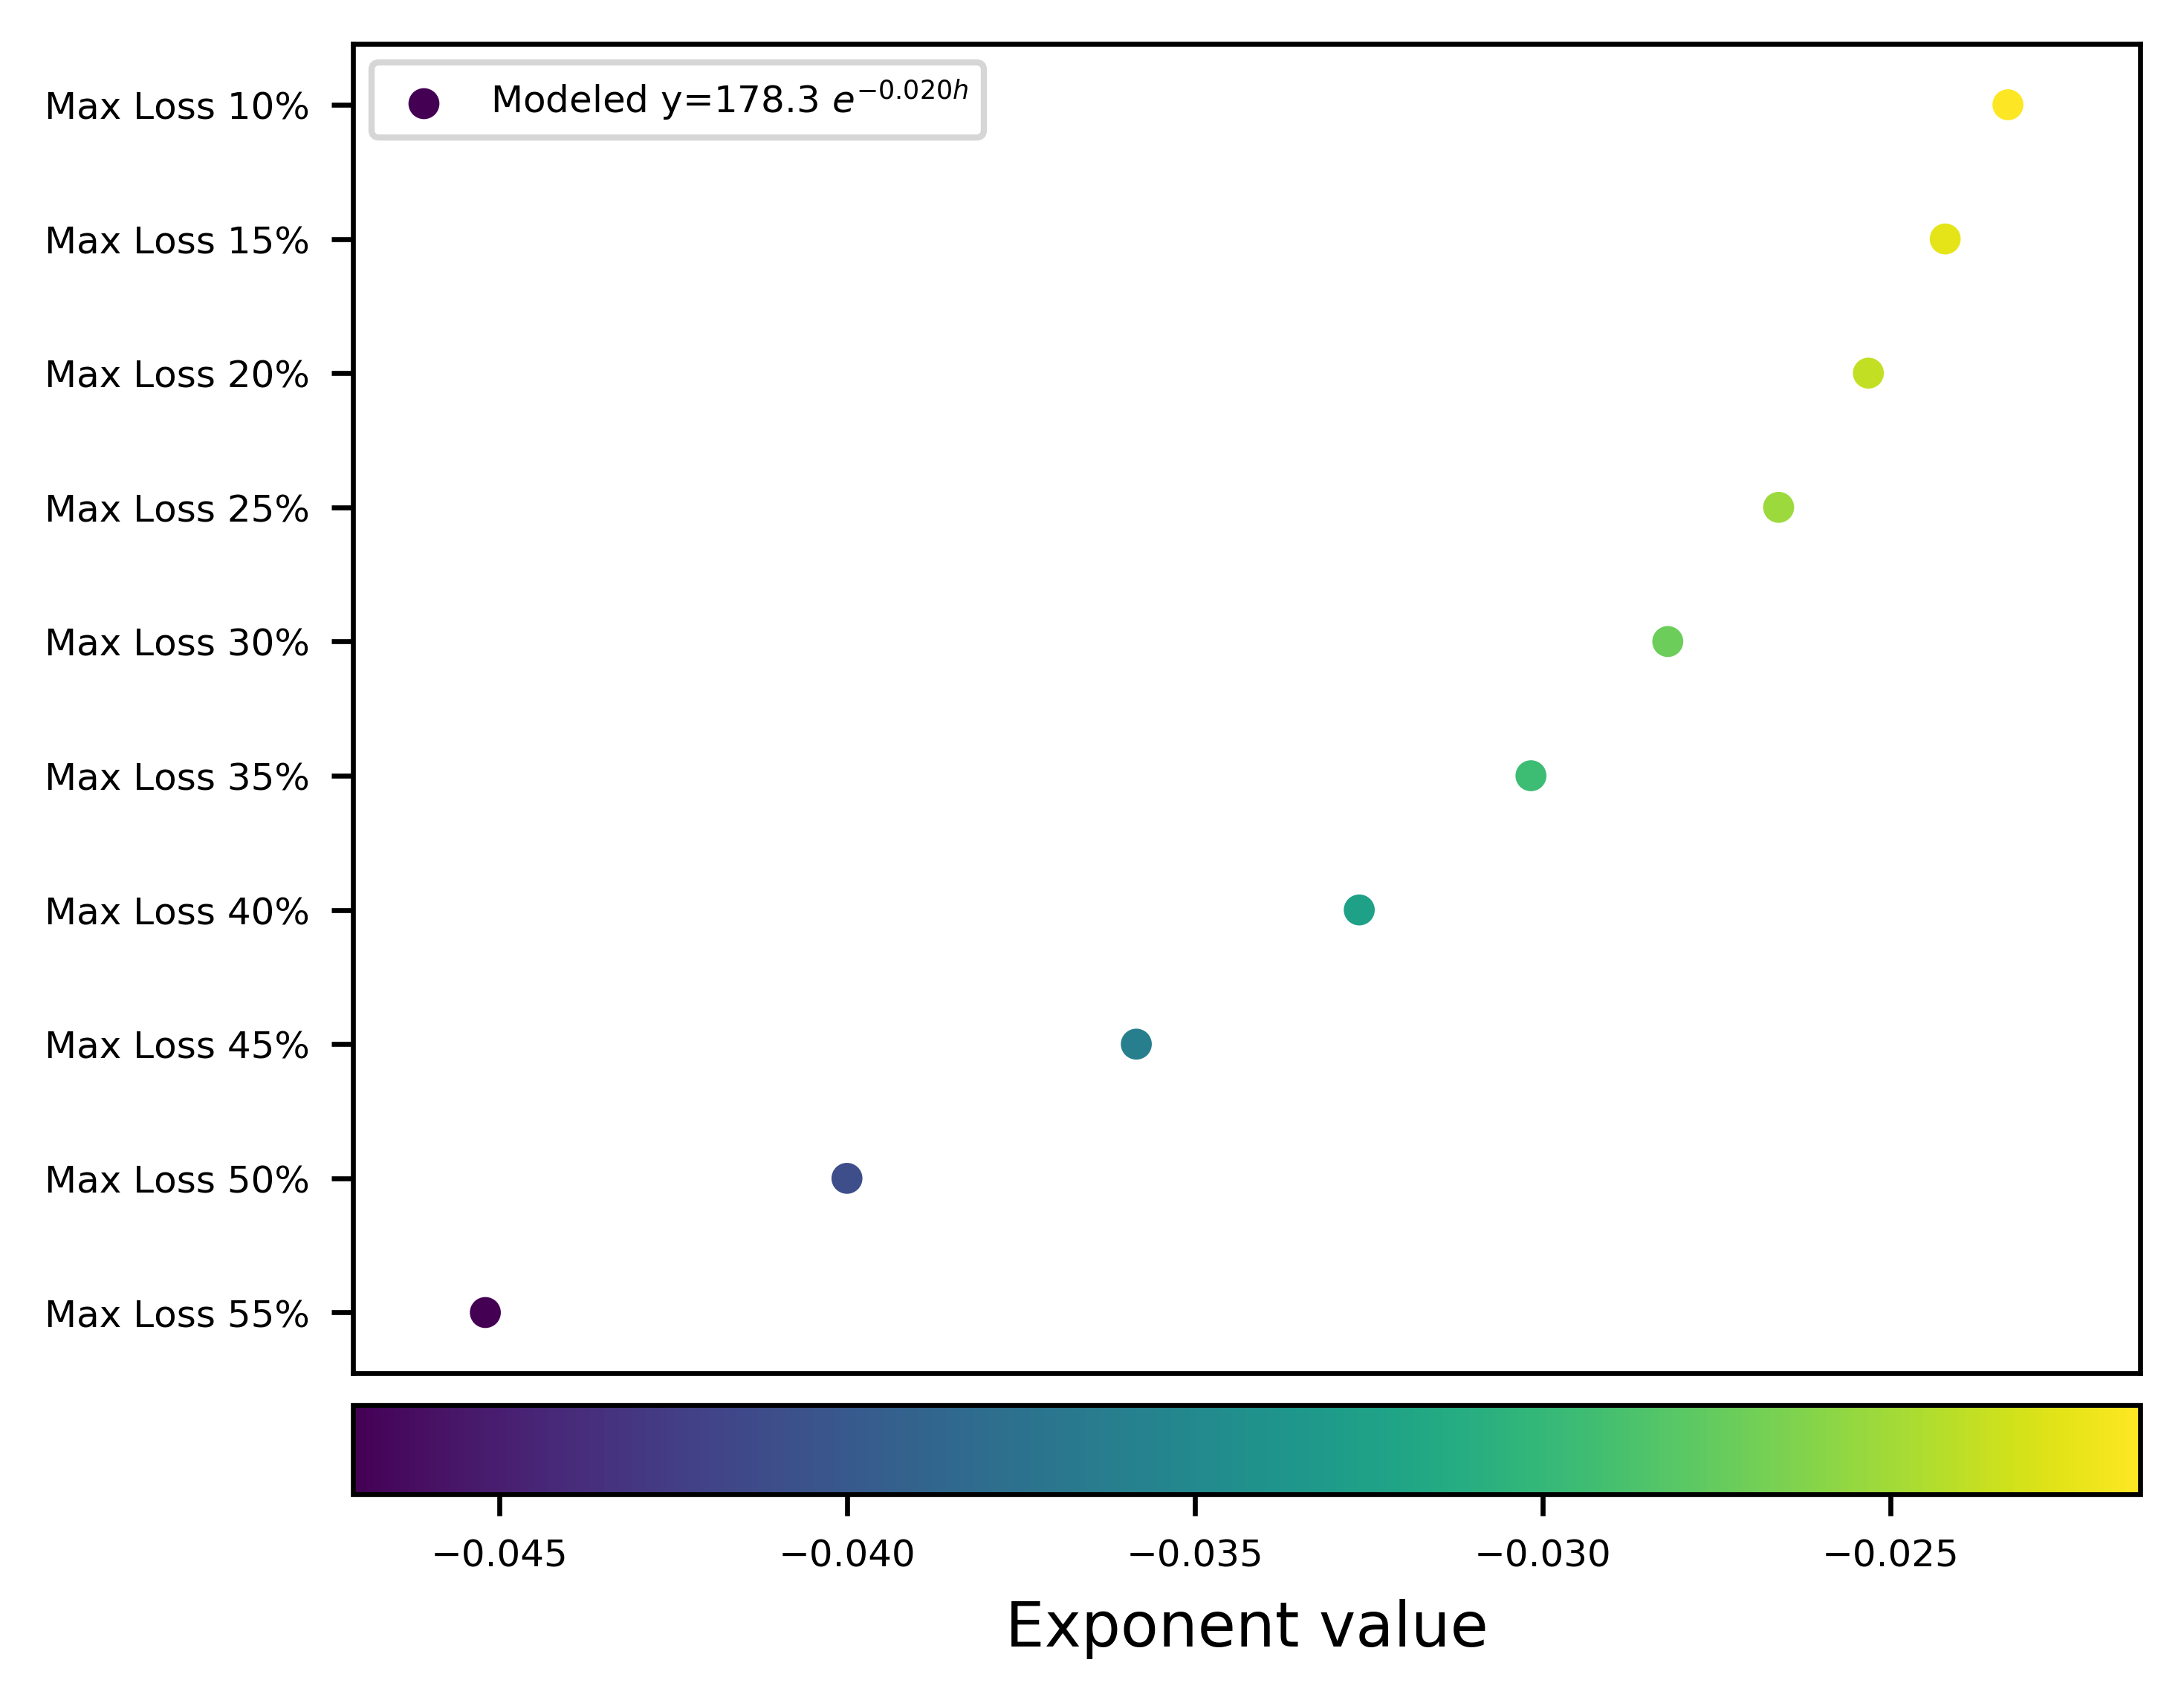

In [792]:
colormap = plt.get_cmap('hsv')
vmax = max(EXP_best_fit_expon_val)

fig, ax = plt.subplots(figsize=(5,4))

ss = ax.scatter(EXP_best_fit_expon_val, EXP_max_loss_in_percentage, s=16, c=EXP_best_fit_expon_val, 
                label='Modeled y=%5.1f $e^{%5.3f h}$' %tuple(EXP_steady_state_popt))

ax.invert_yaxis()
ax.set_xticks([])

# Colorbar  -------------------------------------------------------------------------------
fig.colorbar(ss, orientation='horizontal', pad=0.02, 
              label='Exponent value')

loc = mtick.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.legend()

fig.tight_layout()
#plt.savefig('exponential_spf_exp_change.png')
plt.show()

## PART III - Mean-centered sp/sd
### Regression to determine production function coefficients

In [793]:
MC_result = [] # initialize lists
MC_label = []
MC_covariance = []

for d in MC_df_stripped_soil_pits.columns:
    xdata = MC_df_stripped_soil_pits[d] # loop through depths
    ydata = MC_truncated_SP_rate.loc[:,MC_truncated_SP_rate.columns.str.startswith(d)].squeeze() 
    # soil production rates corresponding to the depth array
        
    popt, pcov = curve_fit(exponential_fit, xdata, ydata, p0=(100,0.001))
    # find parameters for the exponential regression 
    
    MC_result.append(popt) # store results
    MC_label.append(d) # store labels
    MC_covariance.append(pcov)

In [794]:
MC_spf_dict = dict(zip(MC_label, MC_result))
MC_spf_dict

{'Max Loss 55%': array([ 1.18890787e+02, -1.22047019e-02]),
 'Max Loss 60%': array([ 1.32178941e+02, -1.68174796e-02]),
 'Max Loss 65%': array([ 1.57622194e+02, -2.50093095e-02]),
 'Max Loss 70%': array([ 1.80420207e+02, -3.22430023e-02]),
 'Max Loss 75%': array([ 1.68358320e+02, -3.02641763e-02]),
 'Max Loss 80%': array([ 1.49208340e+02, -2.53232401e-02]),
 'Max Loss 85%': array([ 1.35462721e+02, -2.10596009e-02]),
 'Max Loss 90%': array([ 1.27511488e+02, -1.83484448e-02]),
 'Max Loss 95%': array([ 1.22526497e+02, -1.65593094e-02]),
 'Max Loss 100%': array([ 1.19152338e+02, -1.52888038e-02])}

In [795]:
MC_best_fit_expon_val = [elem[1] for elem in MC_spf_dict.values()] # list containing best fit exponent values
MC_max_loss_in_percentage = list(MC_spf_dict.keys()) # list containing the percent loss

In [796]:
print ("mean :", np.mean(MC_best_fit_expon_val))
print ("standard deviation:", np.std(MC_best_fit_expon_val))
print ("range:", max(MC_best_fit_expon_val), "to", min(MC_best_fit_expon_val))

mean : -0.021311806863687728
standard deviation: 0.006326494556764439
range: -0.012204701941788288 to -0.03224300234891595


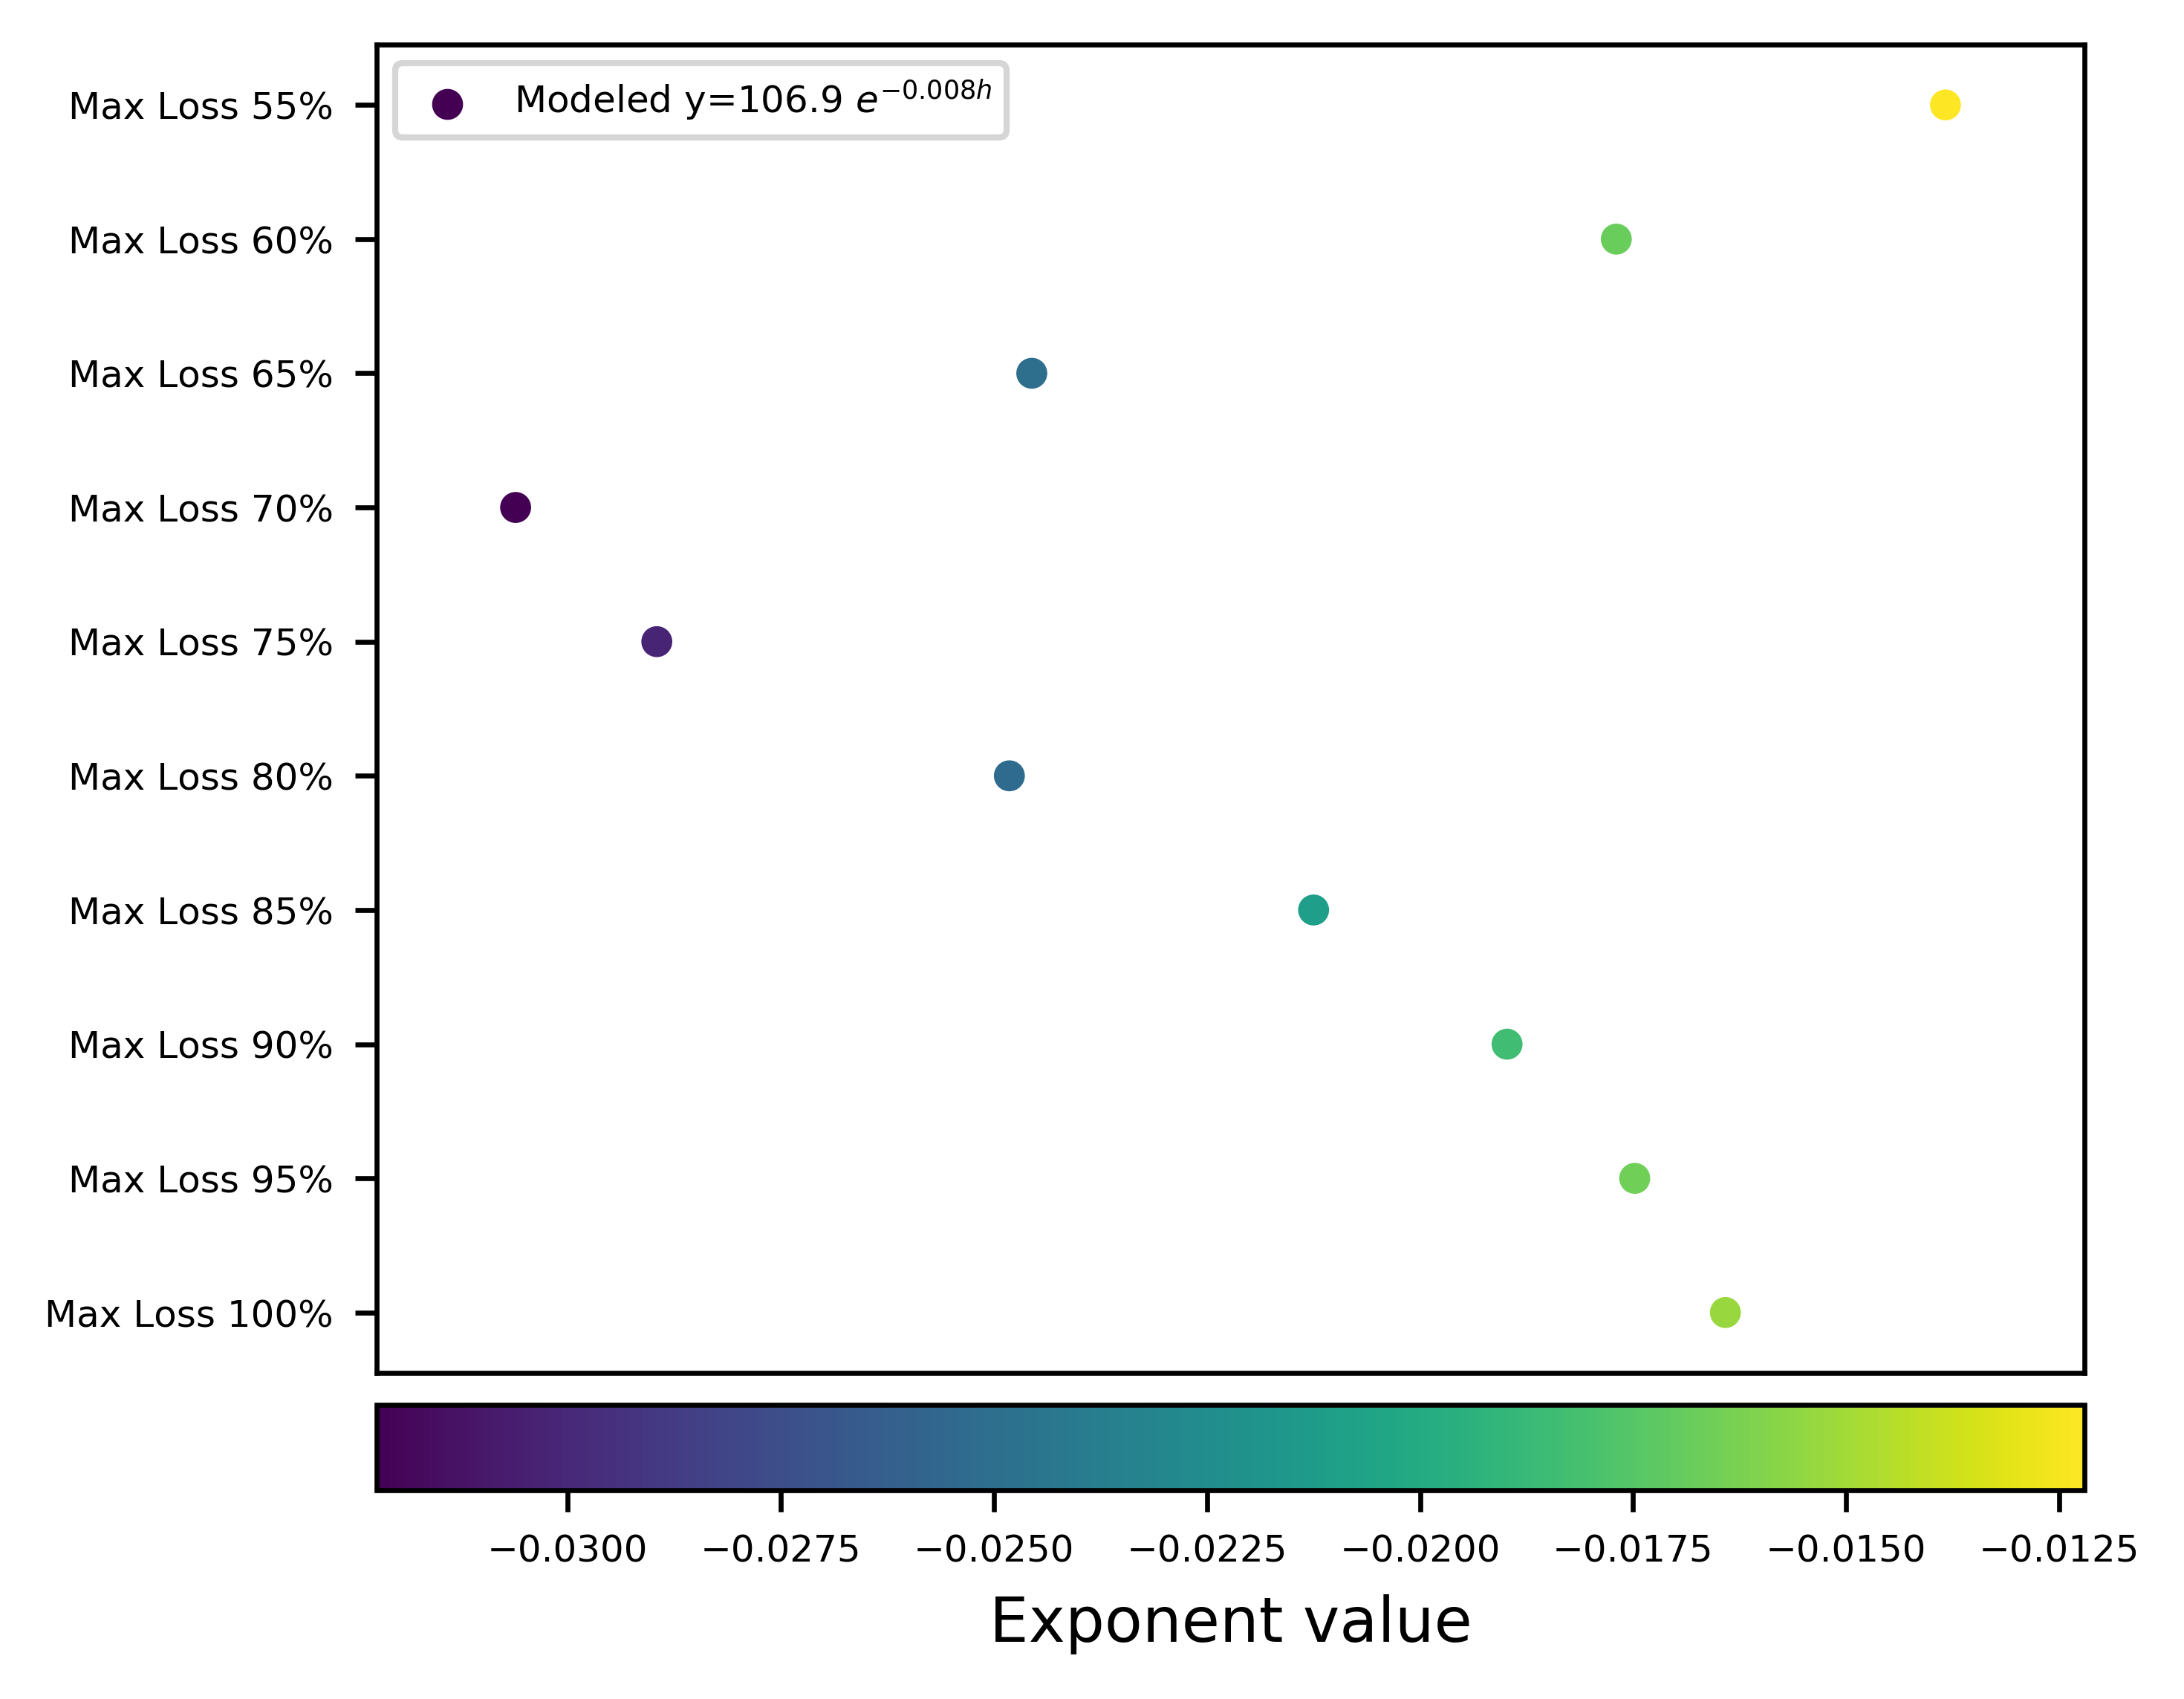

In [797]:
colormap = plt.get_cmap('hsv')
vmax = max(MC_best_fit_expon_val)

fig, ax = plt.subplots(figsize=(5,4))

ss = ax.scatter(MC_best_fit_expon_val, MC_max_loss_in_percentage, s=16, c=MC_best_fit_expon_val, 
                label='Modeled y=%5.1f $e^{%5.3f h}$' %tuple(MC_steady_state_popt))

ax.invert_yaxis()
ax.set_xticks([])

# Colorbar  -------------------------------------------------------------------------------
fig.colorbar(ss, orientation='horizontal', pad=0.02, 
              label='Exponent value')

loc = mtick.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.legend()

fig.tight_layout()
#plt.savefig('mean_centered_spf_exp_change.png')
plt.show()

In [798]:
EXP_truncated_SP_rate['Max Loss 55%']

0    121.525121
1    123.847461
2     86.385753
3    103.767376
4     96.382371
5     70.020780
6     93.051754
7     69.467089
8     79.671764
9     73.987695
Name: Max Loss 55%, dtype: float64

In [799]:
EXP_df_stripped_soil_pits['Max Loss 55%']

0    18.0
1    20.8
2    23.1
3    25.0
4    26.4
5    27.4
6    28.0
7    28.1
8    27.8
9    27.0
Name: Max Loss 55%, dtype: float64

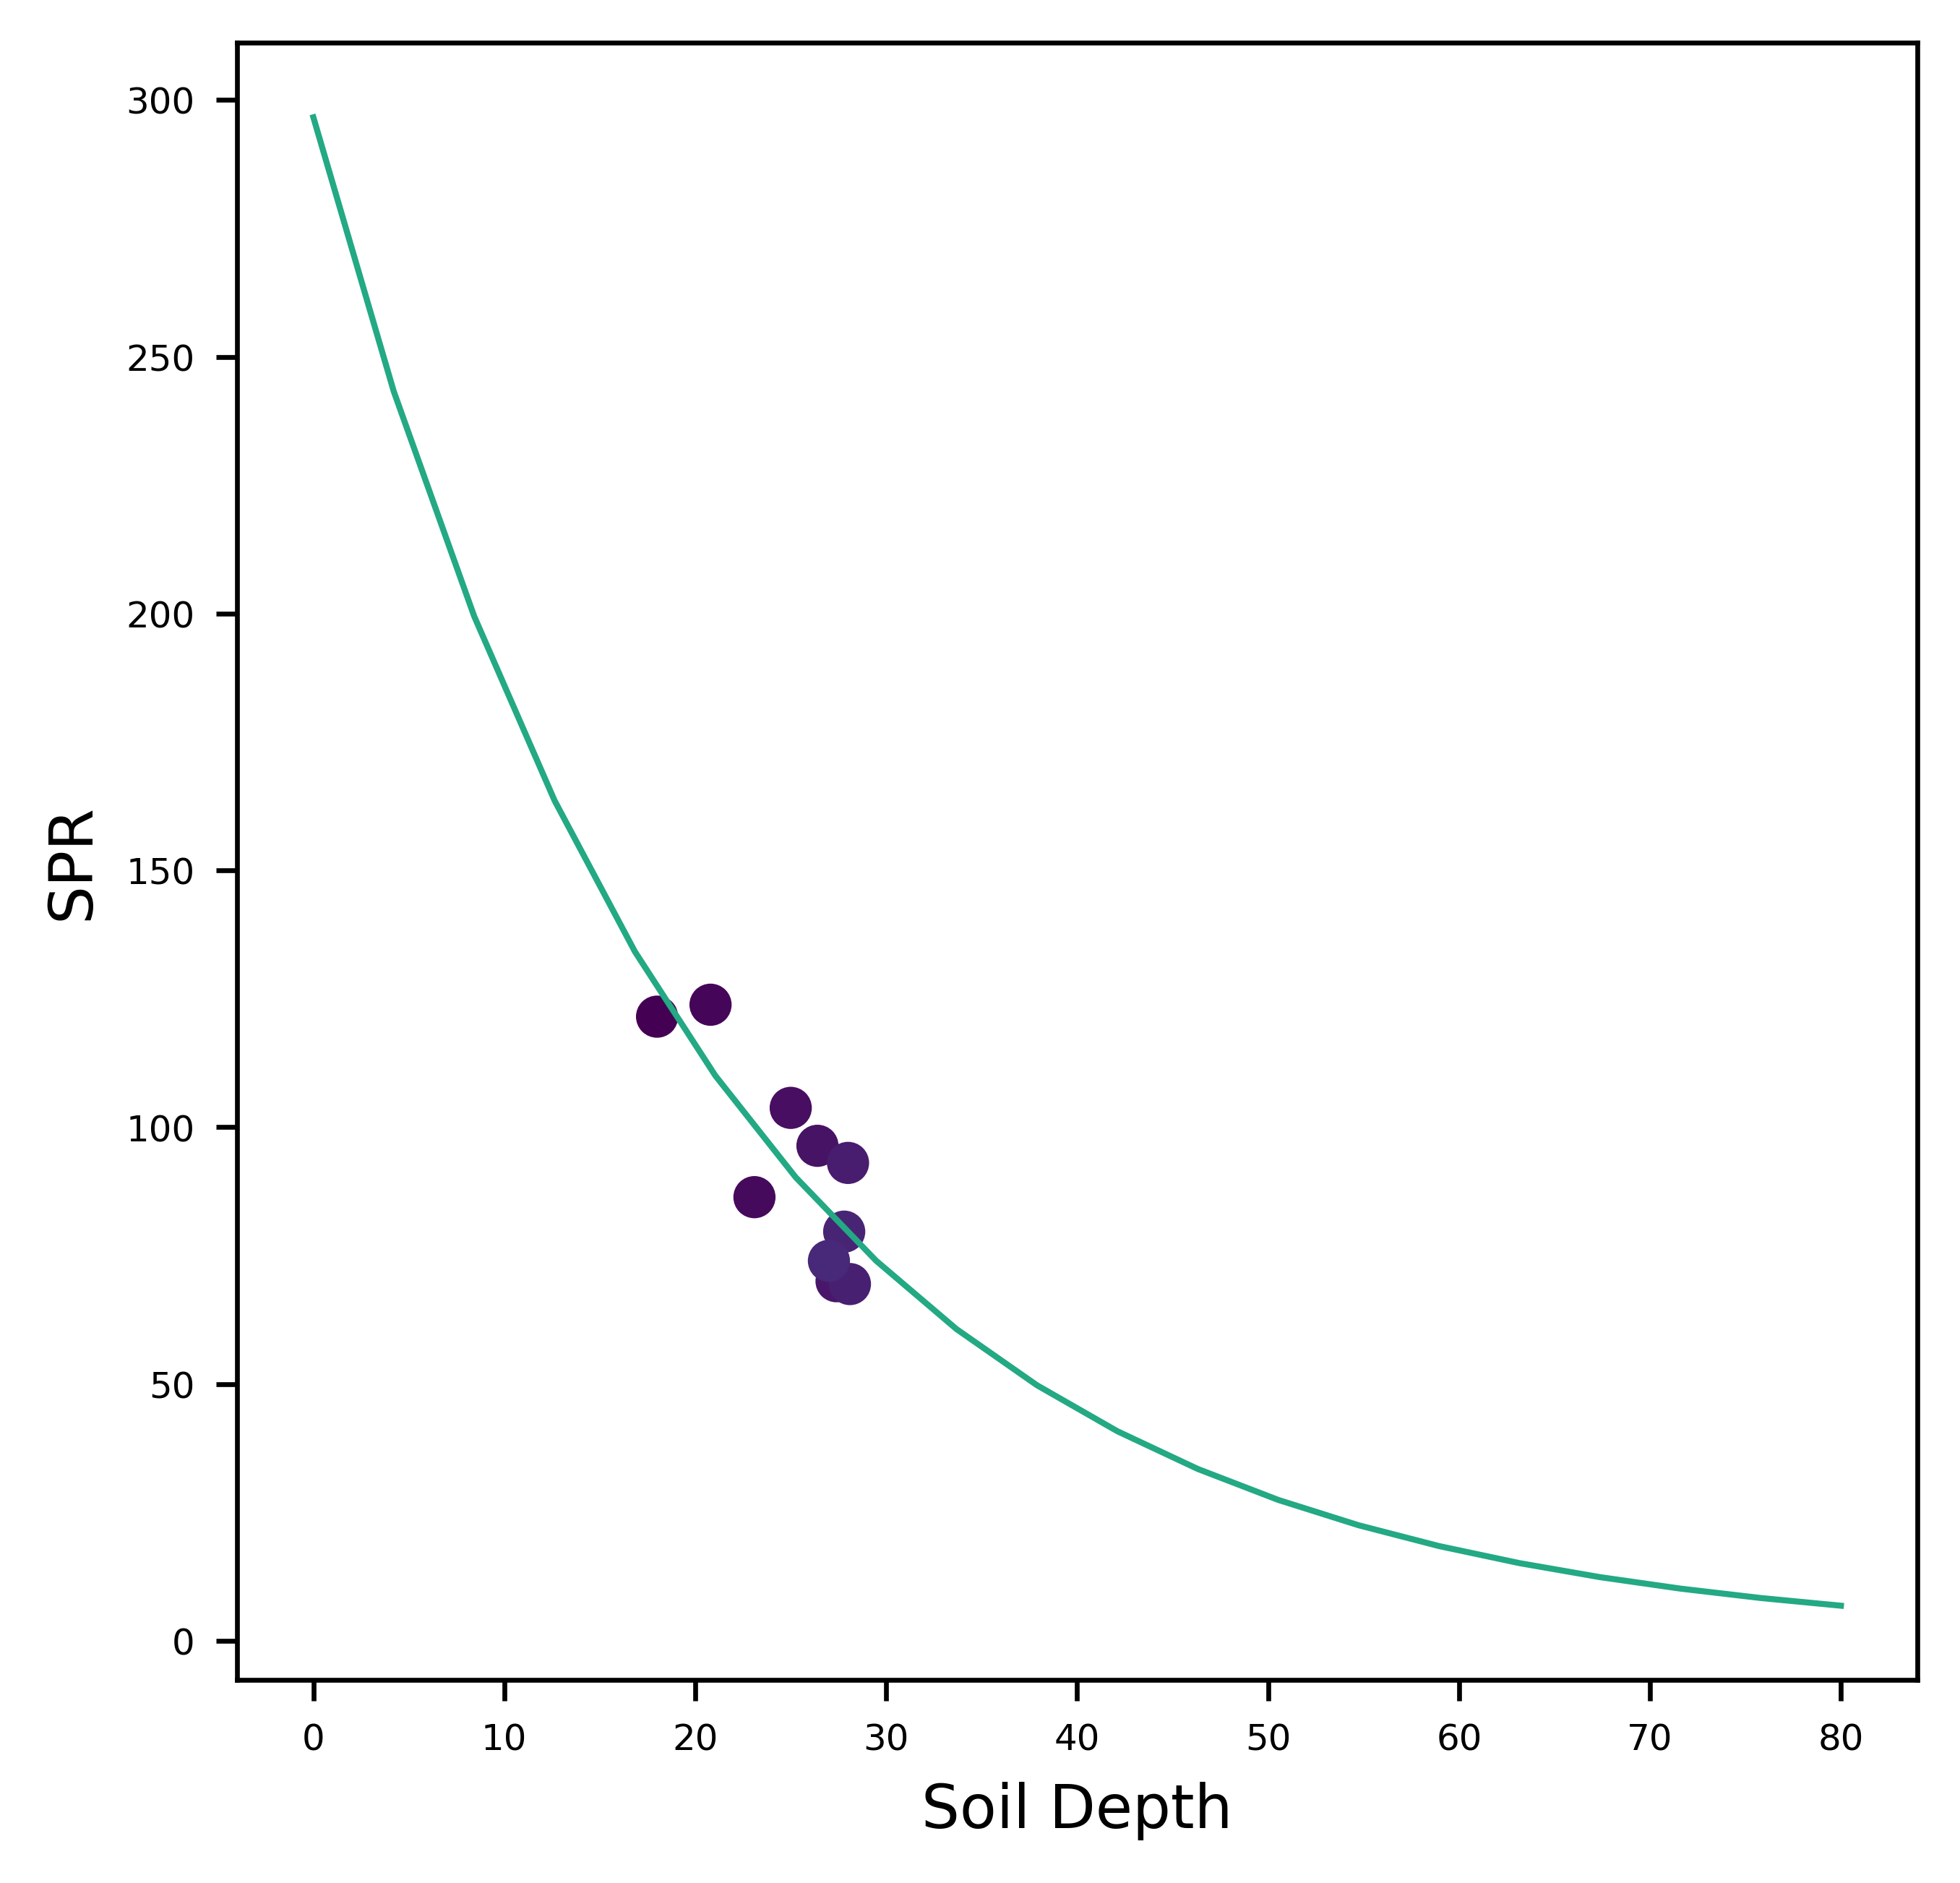

In [800]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(EXP_df_stripped_soil_pits['Max Loss 55%'], EXP_truncated_SP_rate['Max Loss 55%'],
                 c=EXP_df_erode_at_intervals['2'], norm=norm_exp, zorder=2)

# Max Loss 60
ax.plot(x_axis, exponential_fit(x_axis, *EXP_spf_dict['Max Loss 55%']), color = match_color(EXP_spf_dict['Max Loss 55%'][1]), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(EXP_spf_dict['Max Loss 55%']))

ax.set_ylabel('SPR')
ax.set_xlabel('Soil Depth')

plt.show()

## PART III
### Visualize the model results and compare to published studies

Generate a dictionary that stores some coefficients of fit from the published literature:

In [801]:
published_dict = ({'NZ': [1815, -0.058],
                  'TV': [86.14, -0.024],
                  'SG': [160.77, -0.033],
                  'SK': [40.39, -0.00077],
                  'SA': [5.530480, -0.001136],
                  'CA': [84.58, -0.017],
                  'OR': [157.35, -0.01]})

An array representing theoretical soil depths is generated for the plot:

In [802]:
x_axis = np.linspace(0, 80, num=20)

Define a function for controlling the plot tick style:

In [803]:
def ticks(y, pos):
    return r'$e^{:.0f}$'.format(np.log(y))

Call on the values stored in the dictionary "spf_dict" to plot the soil production function of each modeled scenario:

In [804]:
def match_color(exponent):
    cmap = mpl.cm.get_cmap('viridis')
    norm = mpl.colors.Normalize(vmin=-0.1, vmax=vmax)
    rgba = cmap(norm(exponent))
    
    return rgba

In [805]:
#rcParams.keys()

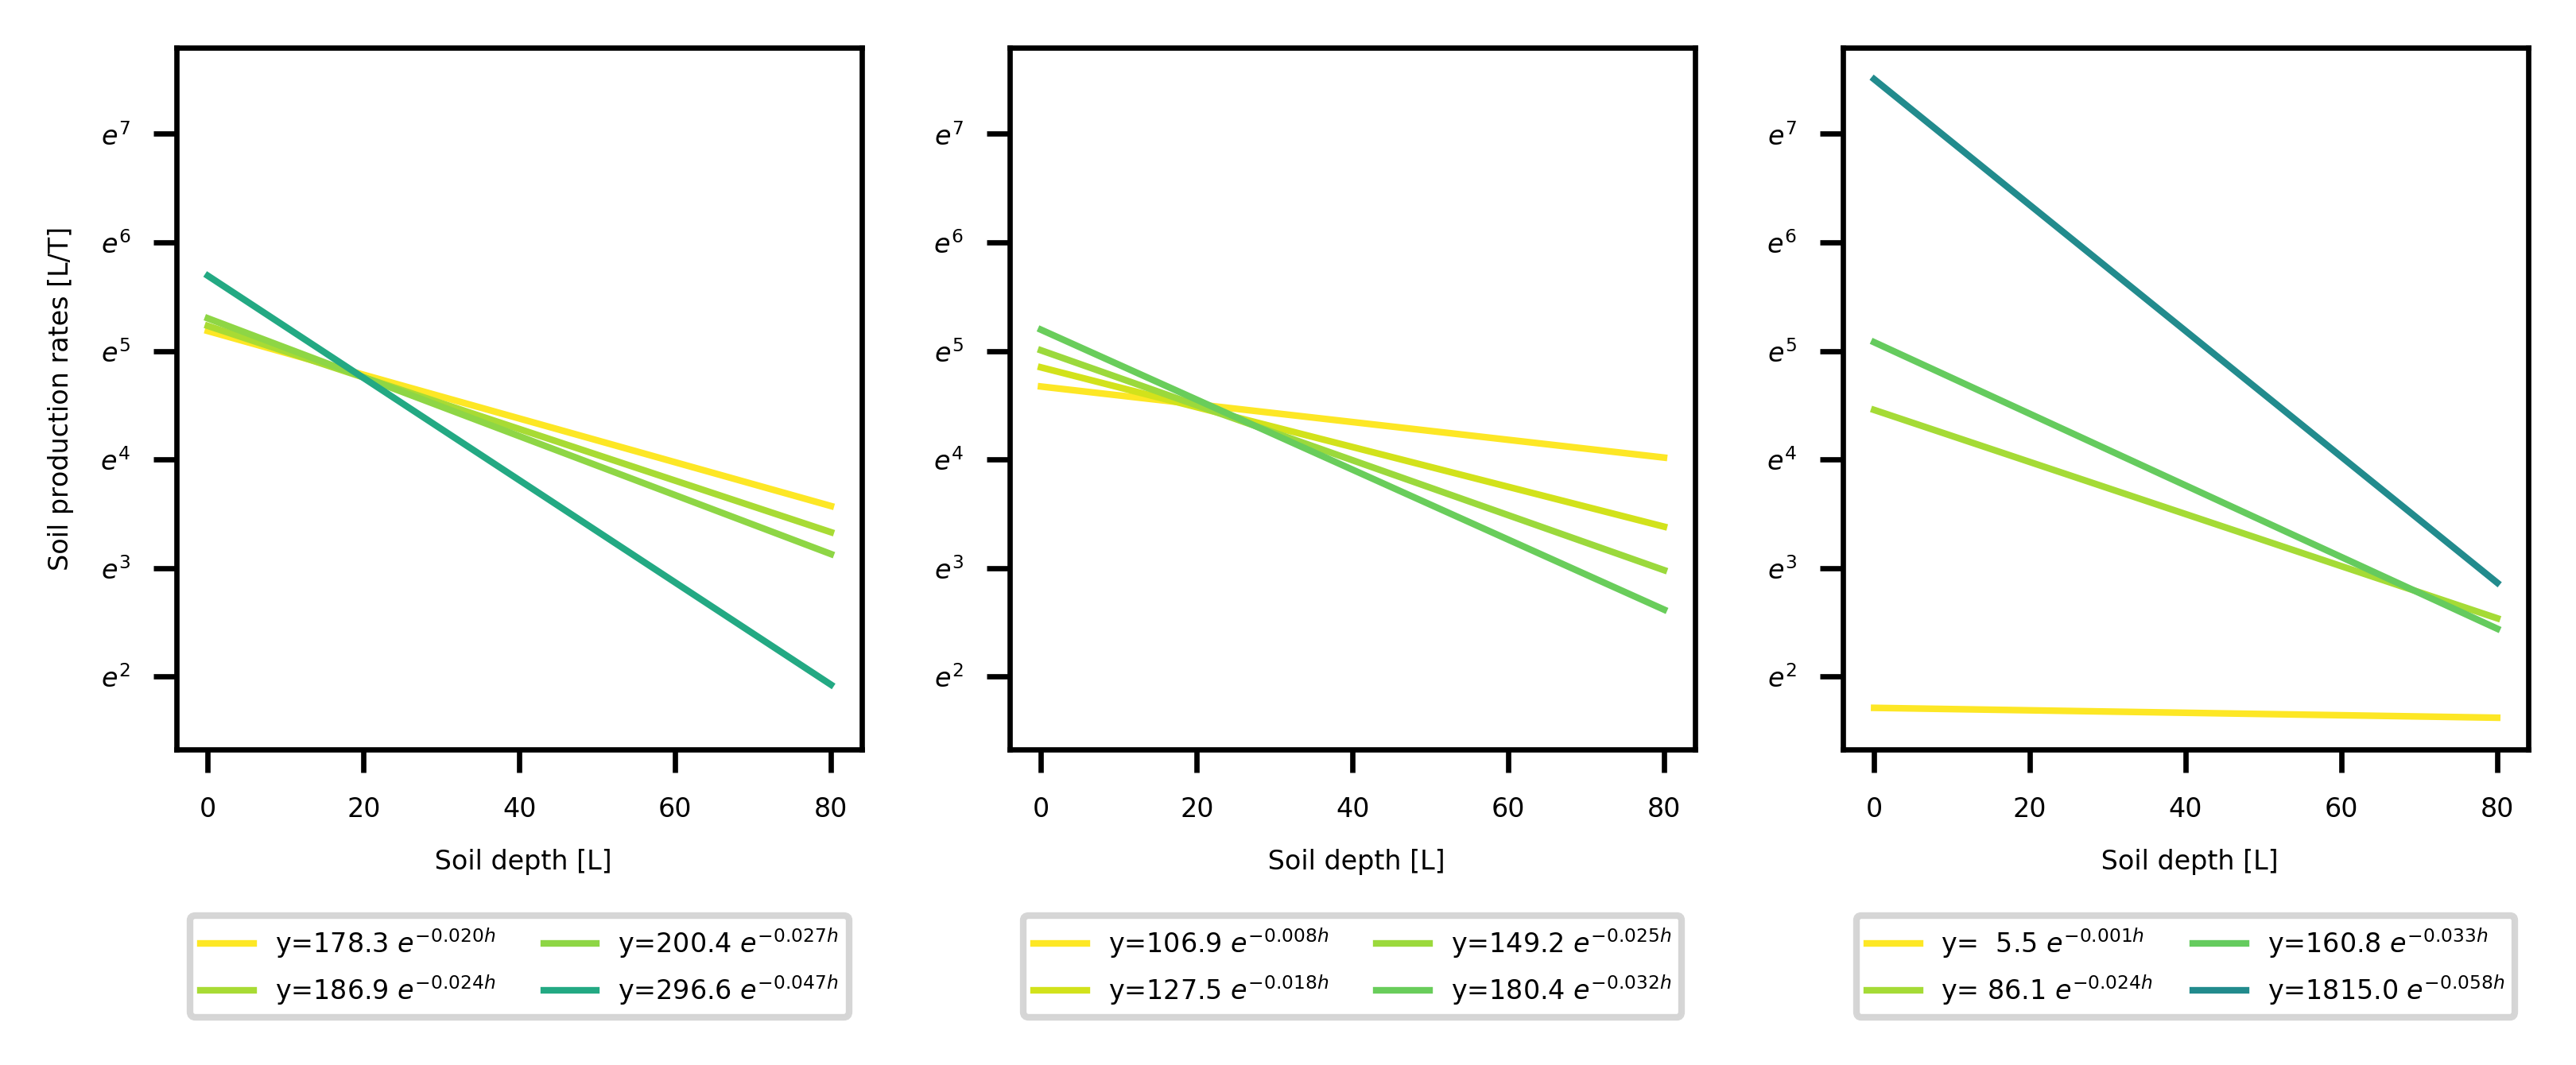

In [807]:
# Figure size and resolution
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = [5.5, 2.5]


# Text, labels, lines
plt.rcParams['xtick.labelsize'] = 4
plt.rcParams['ytick.labelsize'] = 4
plt.rcParams['legend.fontsize'] = 4
plt.rcParams['axes.labelsize'] = 4
plt.rcParams['axes.titlesize'] = 6
plt.rcParams['lines.linewidth'] = 1



fig, (ax, ax1, ax2) = plt.subplots(1,3, sharey=True)

# Visualize initial = Exponential spfs -------------------------------------------------

ax.plot(x_axis, exponential_fit(x_axis, *EXP_steady_state_popt), color = match_color(MC_steady_state_popt[1]), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(EXP_steady_state_popt))

# Max Loss 21
ax.plot(x_axis, exponential_fit(x_axis, *EXP_spf_dict['Max Loss 20%']), color = match_color(EXP_spf_dict['Max Loss 20%'][1]), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(EXP_spf_dict['Max Loss 20%']))


# Max Loss 33
ax.plot(x_axis, exponential_fit(x_axis, *EXP_spf_dict['Max Loss 30%']), color = match_color(EXP_spf_dict['Max Loss 30%'][1]), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(EXP_spf_dict['Max Loss 30%']))

# Max Loss 45
ax.plot(x_axis, exponential_fit(x_axis, *EXP_spf_dict['Max Loss 55%']), color = match_color(EXP_spf_dict['Max Loss 55%'][1]), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(EXP_spf_dict['Max Loss 55%']))

# Visualize initial = Mean Centered spfs -------------------------------------------------

ax1.plot(x_axis, exponential_fit(x_axis, *MC_steady_state_popt), color = match_color(MC_steady_state_popt[1]), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(MC_steady_state_popt))

# Max Loss 60
ax1.plot(x_axis, exponential_fit(x_axis, *MC_spf_dict['Max Loss 90%']), color = match_color(MC_spf_dict['Max Loss 90%'][1]), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(MC_spf_dict['Max Loss 90%']))


# Max Loss 80
ax1.plot(x_axis, exponential_fit(x_axis, *MC_spf_dict['Max Loss 80%']), color = match_color(MC_spf_dict['Max Loss 80%'][1]), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(MC_spf_dict['Max Loss 80%']))

# Max Loss 100
ax1.plot(x_axis, exponential_fit(x_axis, *MC_spf_dict['Max Loss 70%']), color = match_color(MC_spf_dict['Max Loss 70%'][1]), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(MC_spf_dict['Max Loss 70%']))



# Compare to published soil production functions -------------------------------------------------

# Kruger Park, SOuth Africa
ax2.plot(x_axis, exponential_fit(x_axis, *published_dict['SA']), color = match_color(published_dict['SA'][1]), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(published_dict['SA']))

# Tennessee Valley, CA, USA
ax2.plot(x_axis, exponential_fit(x_axis, *published_dict['TV']), color = match_color(published_dict['TV'][1]), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(published_dict['TV']))

# San Gabriels, CA, USA
ax2.plot(x_axis, exponential_fit(x_axis, *published_dict['SG']), color = match_color(published_dict['SG'][1]), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(published_dict['SG']))

# Southern Alips, New Zealand
ax2.plot(x_axis, exponential_fit(x_axis, *published_dict['NZ']), color = match_color(published_dict['NZ'][1]), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(published_dict['NZ']))


# Plot parameters -------------------------------------------------------------------------------

# Exponential

ax.semilogy(basey=np.e)   # y to log scale
ax.yaxis.set_major_formatter(mtick.FuncFormatter(ticks)) # e^
ax.legend(bbox_to_anchor=(0., -0.4, 1., 1.), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.5)
ax.set_ylabel('Soil production rates [L/T]')
ax.set_xlabel(' Soil depth [L]')
#ax.set_title('Soil production functions of \nexponential model')

# Mean centered

ax1.semilogy(basey=np.e)   
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(ticks))
ax1.yaxis.set_tick_params(labelleft=True)
ax1.legend(bbox_to_anchor=(0., -0.4, 1., 1.), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.5)
ax1.set_xlabel(' Soil depth [L]')
#ax1.set_title('Soil production functions from \nmean-centered model')


# Empirical

ax2.semilogy(basey=np.e)   
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(ticks))
ax2.yaxis.set_tick_params(labelleft=True)
ax2.legend(bbox_to_anchor=(0., -0.4, 1., 1.), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.5)
ax2.set_xlabel(' Soil depth [L]')
#ax2.set_title('Soil production functions from \npublished studies')

plt.tight_layout()
#plt.savefig('example_figure3_ver5.png')
plt.show()

In [757]:
# Exponential

ax.semilogy(basey=np.e)   # y to log scale
ax.yaxis.set_major_formatter(mtick.FuncFormatter(ticks)) # e^
ax.legend(bbox_to_anchor=(0., -0.5, 1., 1.), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.5)
ax.set_ylabel('Soil production rates [L/T]')
ax.set_xlabel(' Soil depth [L]')
ax.set_title('Soil production functions of \nexponential model')

# Mean centered

ax1.semilogy(basey=np.e)   
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(ticks))
ax1.yaxis.set_tick_params(labelleft=True)
ax1.legend(bbox_to_anchor=(0., -0.5, 1., 1.), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.5)
ax1.set_xlabel(' Soil depth [L]')
ax1.set_title('Soil production functions from \nmean-centered model')


# Empirical

ax2.semilogy(basey=np.e)   
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(ticks))
ax2.yaxis.set_tick_params(labelleft=True)
ax2.legend(bbox_to_anchor=(0., -0.5, 1., 1.), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.5)
ax2.set_xlabel(' Soil depth [L]')
ax2.set_title('Soil production functions from \npublished studies')

Text(0.5, 1, 'Soil production functions from \npublished studies')